# Results Visualization - All Objects

Comprehensive visualization of training metrics across all LineMOD objects.

Features:
- Training curves visualization for all objects (loss, rotation error, translation error)
- RGB vs RGBD model comparison across all objects
- Aggregated results summary tables
- Per-object and per-model performance analysis

In [1]:
import os
import sys
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

# Add project root to path
project_root = os.path.dirname(os.getcwd())
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print("Libraries loaded successfully")

Libraries loaded successfully


In [2]:
# ==============================================================================
# CONFIGURATION
# ==============================================================================

# All LineMOD objects
ALL_OBJECTS = [
    'ape', 'benchvise', 'camera', 'can', 'cat', 'driller',
    'duck', 'eggbox', 'glue', 'holepuncher', 'iron', 'lamp', 'phone'
]

# All available pipelines
RGBD_MODELS = [
    'residual_learning',
    'densefusion_iterative',
    'pvn3d',
    'ffb6d'
]

ALL_PIPELINES = [
    ('rgb', 'rgb'),  # RGB pipeline predicts full 6D pose
    ('residual_learning', 'rgbd'),
    ('densefusion_iterative', 'rgbd'),
    ('pvn3d', 'rgbd'),
    ('ffb6d', 'rgbd')
]

print(f"Objects: {len(ALL_OBJECTS)}")
print(f"Pipelines: {len(ALL_PIPELINES)}")

Objects: 13
Pipelines: 5


## 1. Load Training History

In [3]:
def load_history(model_name, object_name, pipeline_type='rgbd'):
    """
    Load training history from JSON file.
    
    Args:
        model_name: Model name (e.g., 'residual_learning' for RGBD, or 'rgb' for RGB)
        object_name: Object name (e.g., 'ape')
        pipeline_type: 'rgb' or 'rgbd'
    
    Returns:
        Normalized history dict with: train_loss, val_loss, rot_err, trans_err
        All translation errors are returned in cm.
    """
    if pipeline_type == 'rgb':
        base_dir = '../trained_checkpoints'
        path = os.path.join(base_dir, object_name, 'history.json')
    else:
        base_dir = '../trained_checkpoints_rgbd'
        path = os.path.join(base_dir, model_name, object_name, 'history.json')
    
    if not os.path.exists(path):
        return None
    
    with open(path, 'r') as f:
        history = json.load(f)
    
    # Normalize to common format
    # RGB uses: train_losses, val_losses, val_angle_errors, val_trans_errors (in METERS)
    # RGBD uses: train_losses, val_losses, val_rot_error, val_trans_error (in CM)
    normalized = {
        'train_loss': history.get('train_loss', history.get('train_losses', [])),
        'val_loss': history.get('val_loss', history.get('val_losses', [])),
        'rot_err': history.get('rot_err', history.get('val_rot_error', history.get('val_angle_errors', []))),
        'trans_err': history.get('trans_err', history.get('val_trans_error', history.get('val_trans_errors', [])))
    }
    
    # RGB pipeline stores translation errors in meters, convert to cm for consistency
    if pipeline_type == 'rgb' and normalized['trans_err']:
        normalized['trans_err'] = [err * 100 for err in normalized['trans_err']]
    
    return normalized


def load_all_histories():
    """
    Load training histories for all objects and pipelines.
    
    Returns:
        Dict with structure: {(model_name, pipeline_type): {object_name: history}}
    """
    all_histories = {}
    
    for model_name, pipeline_type in ALL_PIPELINES:
        key = (model_name, pipeline_type)
        all_histories[key] = {}
        
        for obj_name in ALL_OBJECTS:
            history = load_history(model_name, obj_name, pipeline_type)
            if history is not None:
                all_histories[key][obj_name] = history
    
    return all_histories


# Load all histories
print("Loading training histories for all objects...\n")
all_histories = load_all_histories()

# Print summary
print("Available training histories:")
print("=" * 60)
for (model_name, pipeline_type), obj_histories in all_histories.items():
    display_name = 'RGB (6D Pose)' if pipeline_type == 'rgb' else model_name
    n_objects = len(obj_histories)
    if n_objects > 0:
        print(f"  {display_name:<25} {n_objects:>2} objects")
print("=" * 60)

Loading training histories for all objects...

Available training histories:
  RGB (6D Pose)             13 objects
  residual_learning         13 objects
  densefusion_iterative     13 objects
  pvn3d                     13 objects
  ffb6d                     13 objects


## 2. Training Curves - All Objects

In [4]:
def plot_training_curves_grid(model_name, pipeline_type, objects=None):
    """
    Plot training curves for multiple objects in a grid layout.
    
    Args:
        model_name: Model name
        pipeline_type: 'rgb' or 'rgbd'
        objects: List of object names (default: ALL_OBJECTS)
    """
    if objects is None:
        objects = ALL_OBJECTS
    
    # Filter objects with available history
    available_objects = []
    for obj in objects:
        history = load_history(model_name, obj, pipeline_type)
        if history is not None:
            available_objects.append(obj)
    
    if not available_objects:
        print(f"No training history found for {model_name}")
        return
    
    n_objects = len(available_objects)
    n_cols = min(4, n_objects)
    n_rows = (n_objects + n_cols - 1) // n_cols
    
    display_name = 'RGB (6D Pose)' if pipeline_type == 'rgb' else model_name
    
    # Plot validation loss
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows))
    axes = np.array(axes).reshape(-1) if n_objects > 1 else [axes]
    
    for idx, obj_name in enumerate(available_objects):
        history = load_history(model_name, obj_name, pipeline_type)
        epochs = range(1, len(history['val_loss']) + 1)
        
        axes[idx].plot(epochs, history['train_loss'], 'b-', label='Train', alpha=0.7)
        axes[idx].plot(epochs, history['val_loss'], 'r-', label='Val', alpha=0.7)
        axes[idx].set_title(obj_name, fontsize=10)
        axes[idx].set_xlabel('Epoch', fontsize=8)
        axes[idx].set_ylabel('Loss', fontsize=8)
        axes[idx].legend(fontsize=7)
        axes[idx].grid(True, alpha=0.3)
        axes[idx].tick_params(labelsize=7)
    
    # Hide unused subplots
    for idx in range(len(available_objects), len(axes)):
        axes[idx].set_visible(False)
    
    fig.suptitle(f'{display_name} - Training Loss (All Objects)', fontsize=14, fontweight='bold')
    fig.tight_layout()
    plt.show()
    
    # Plot rotation error
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows))
    axes = np.array(axes).reshape(-1) if n_objects > 1 else [axes]
    
    for idx, obj_name in enumerate(available_objects):
        history = load_history(model_name, obj_name, pipeline_type)
        epochs = range(1, len(history['rot_err']) + 1)
        
        axes[idx].plot(epochs, history['rot_err'], 'g-', linewidth=1.5)
        axes[idx].set_title(obj_name, fontsize=10)
        axes[idx].set_xlabel('Epoch', fontsize=8)
        axes[idx].set_ylabel('Rot Error (deg)', fontsize=8)
        axes[idx].grid(True, alpha=0.3)
        axes[idx].tick_params(labelsize=7)
    
    for idx in range(len(available_objects), len(axes)):
        axes[idx].set_visible(False)
    
    fig.suptitle(f'{display_name} - Rotation Error (All Objects)', fontsize=14, fontweight='bold')
    fig.tight_layout()
    plt.show()
    
    # Plot translation error (if available)
    has_trans = any(
        load_history(model_name, obj, pipeline_type)['trans_err']
        for obj in available_objects
    )
    
    if has_trans:
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows))
        axes = np.array(axes).reshape(-1) if n_objects > 1 else [axes]
        
        for idx, obj_name in enumerate(available_objects):
            history = load_history(model_name, obj_name, pipeline_type)
            trans_err = history['trans_err']
            
            if trans_err and any(e > 0 for e in trans_err):
                epochs = range(1, len(trans_err) + 1)
                axes[idx].plot(epochs, trans_err, 'm-', linewidth=1.5)
            
            axes[idx].set_title(obj_name, fontsize=10)
            axes[idx].set_xlabel('Epoch', fontsize=8)
            axes[idx].set_ylabel('Trans Error (cm)', fontsize=8)
            axes[idx].grid(True, alpha=0.3)
            axes[idx].tick_params(labelsize=7)
        
        for idx in range(len(available_objects), len(axes)):
            axes[idx].set_visible(False)
        
        fig.suptitle(f'{display_name} - Translation Error (All Objects)', fontsize=14, fontweight='bold')
        fig.tight_layout()
        plt.show()

RGB Pipeline - Training Curves


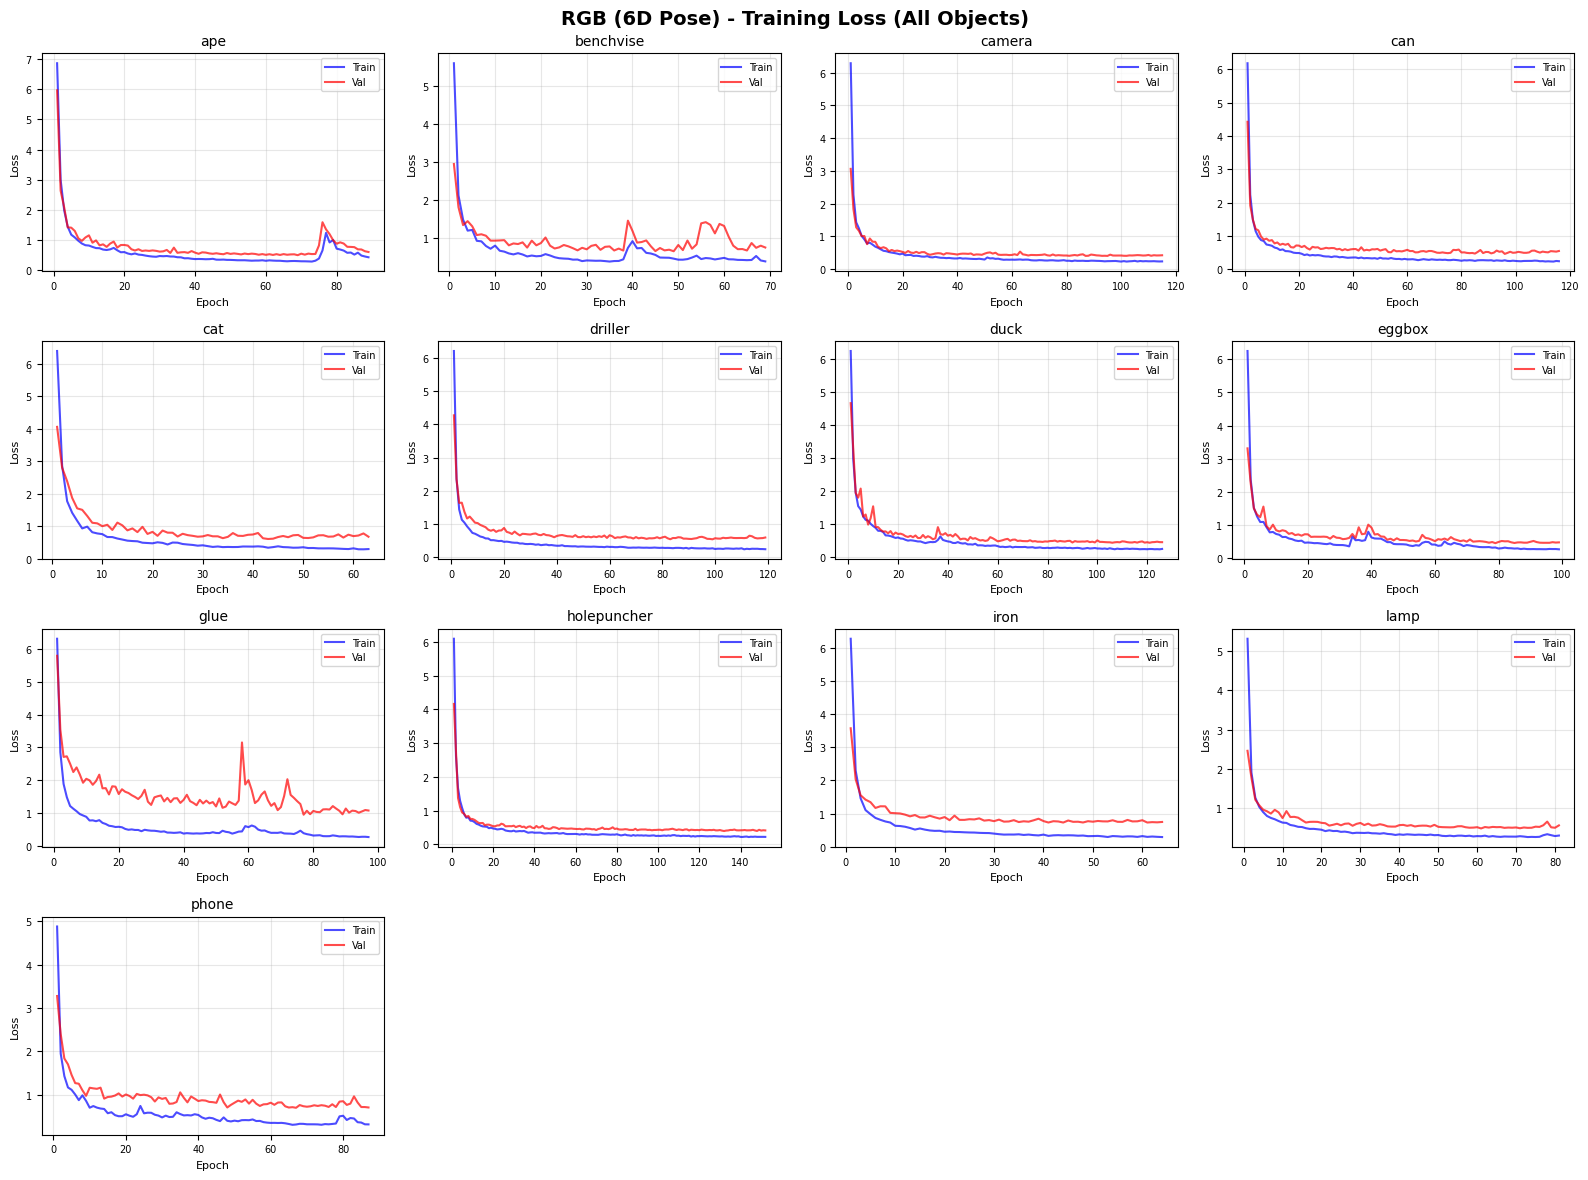

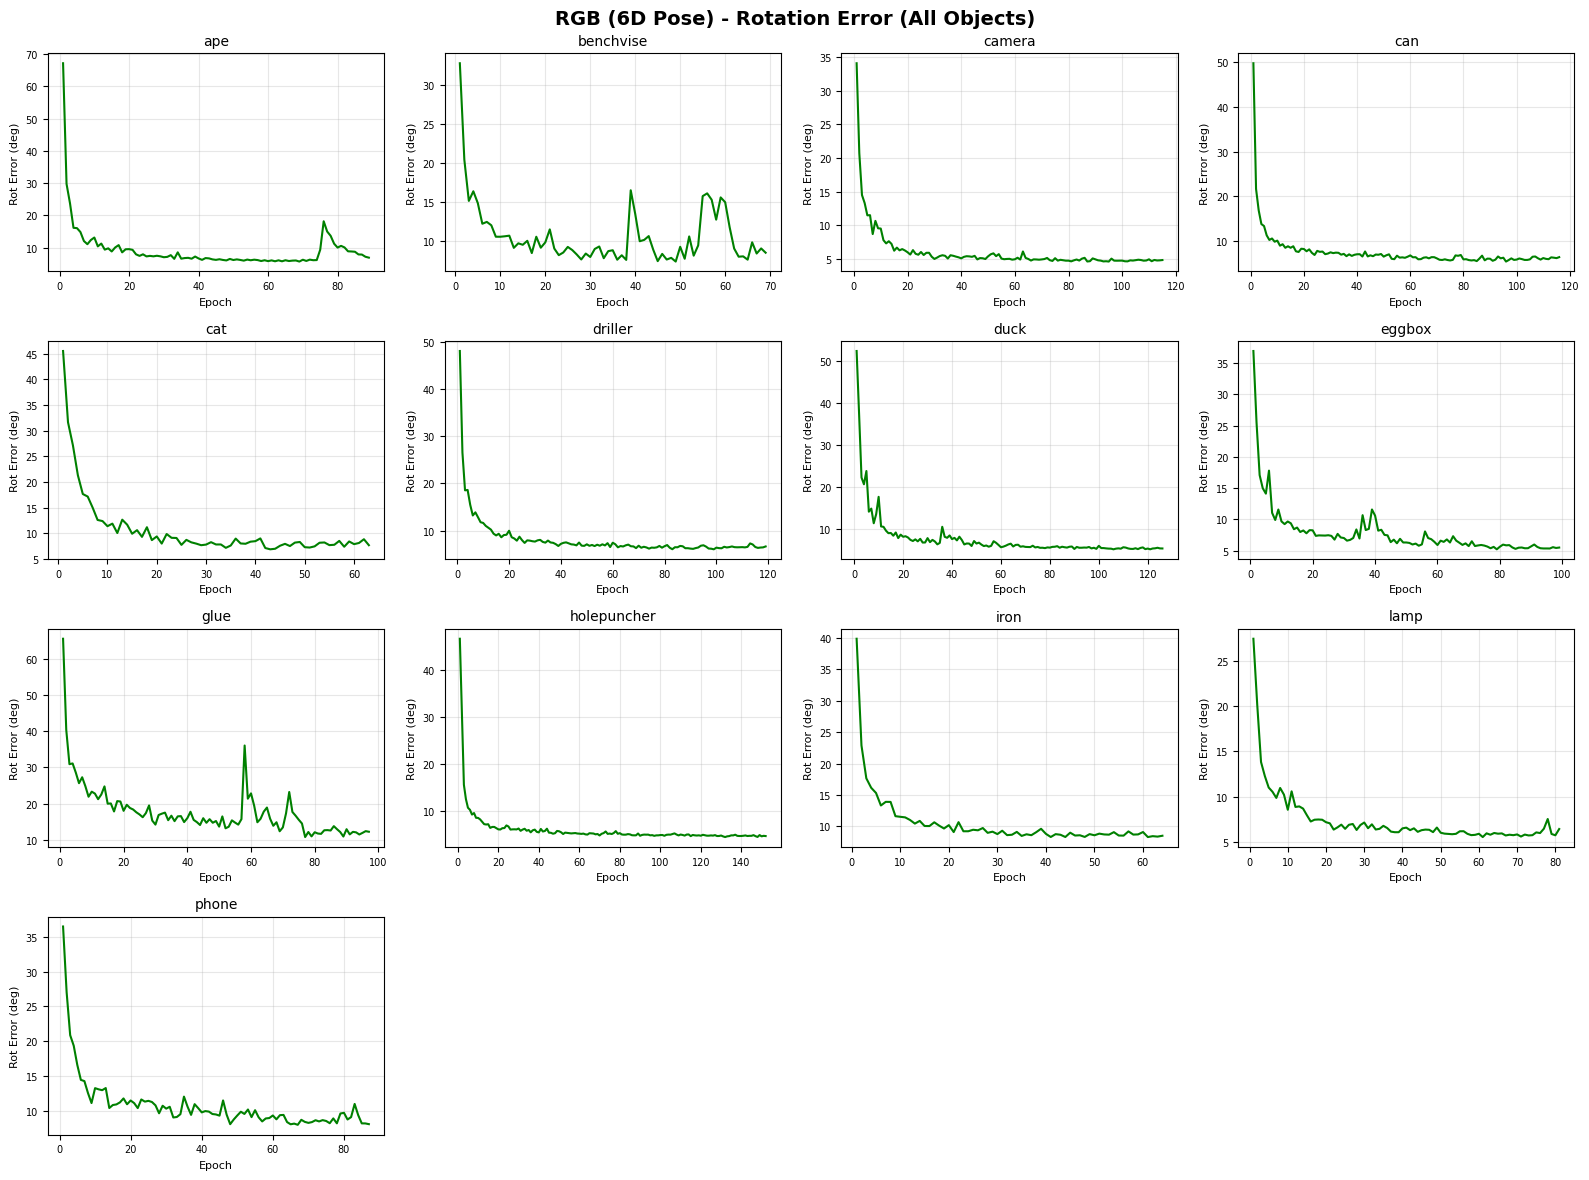

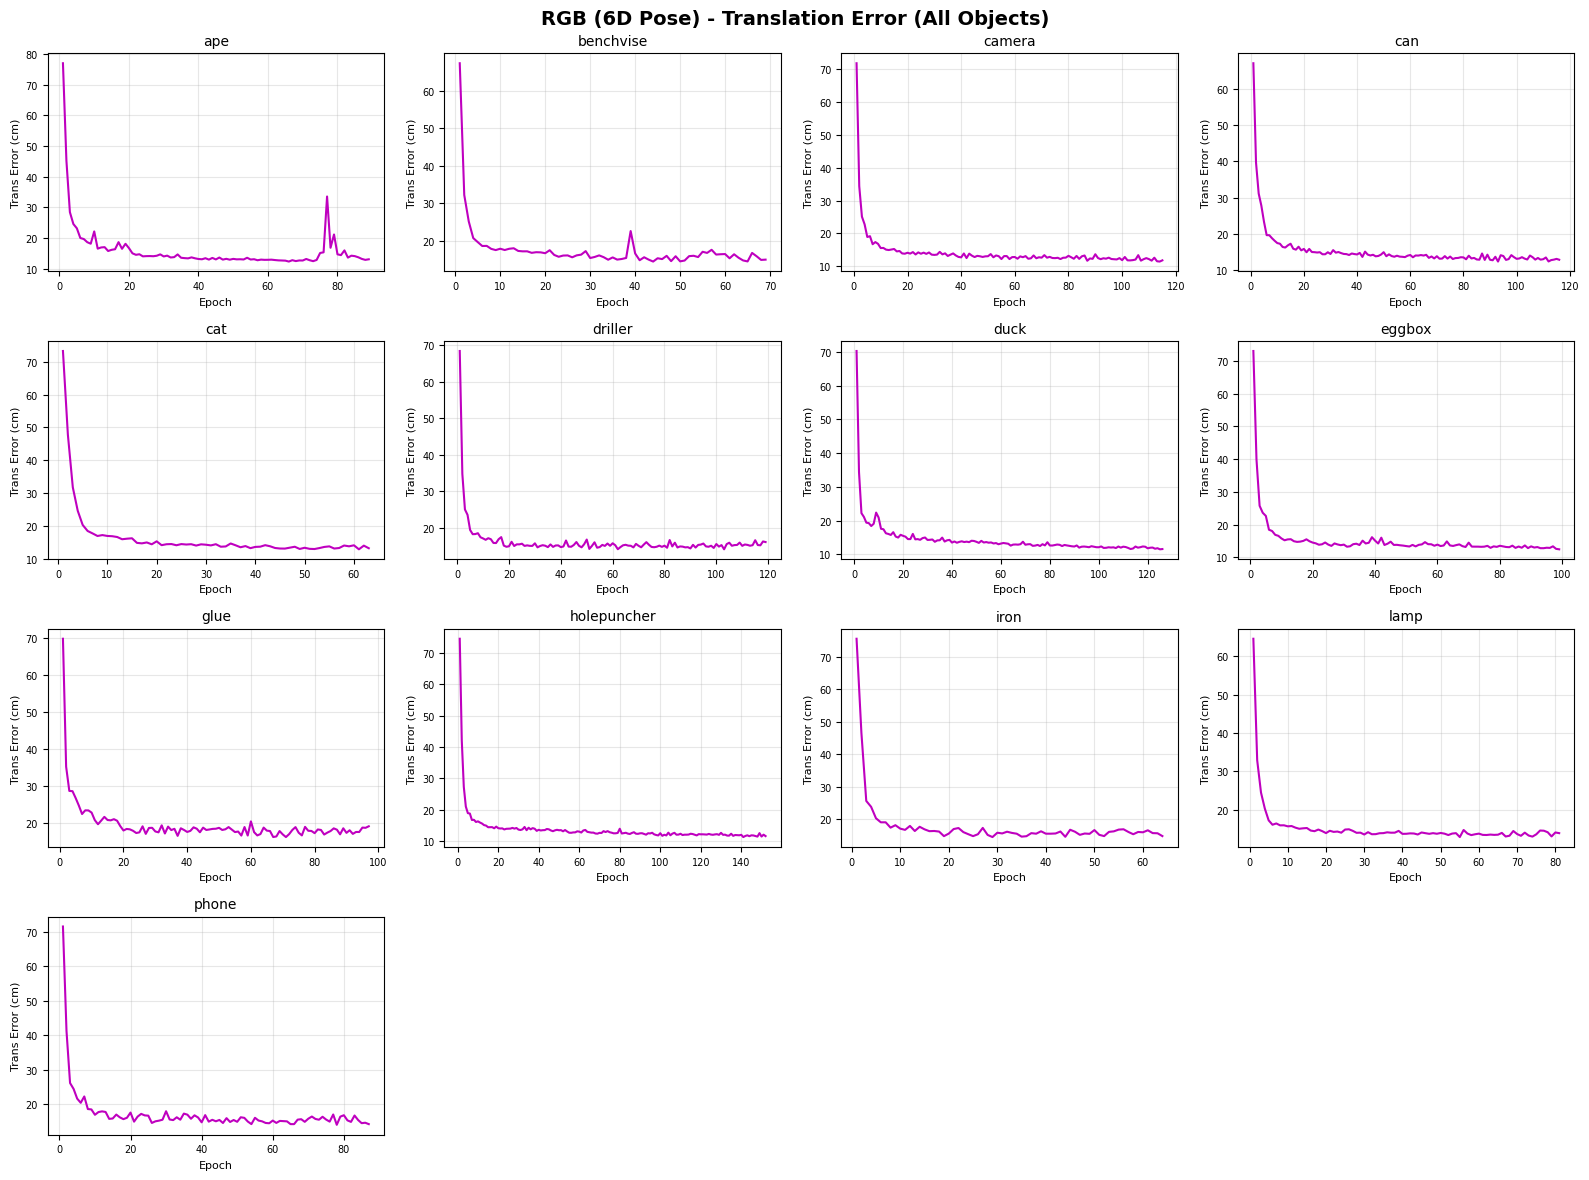

In [5]:
# Plot training curves for RGB pipeline
print("RGB Pipeline - Training Curves")
print("=" * 60)
plot_training_curves_grid('rgb', 'rgb')


RESIDUAL_LEARNING - Training Curves


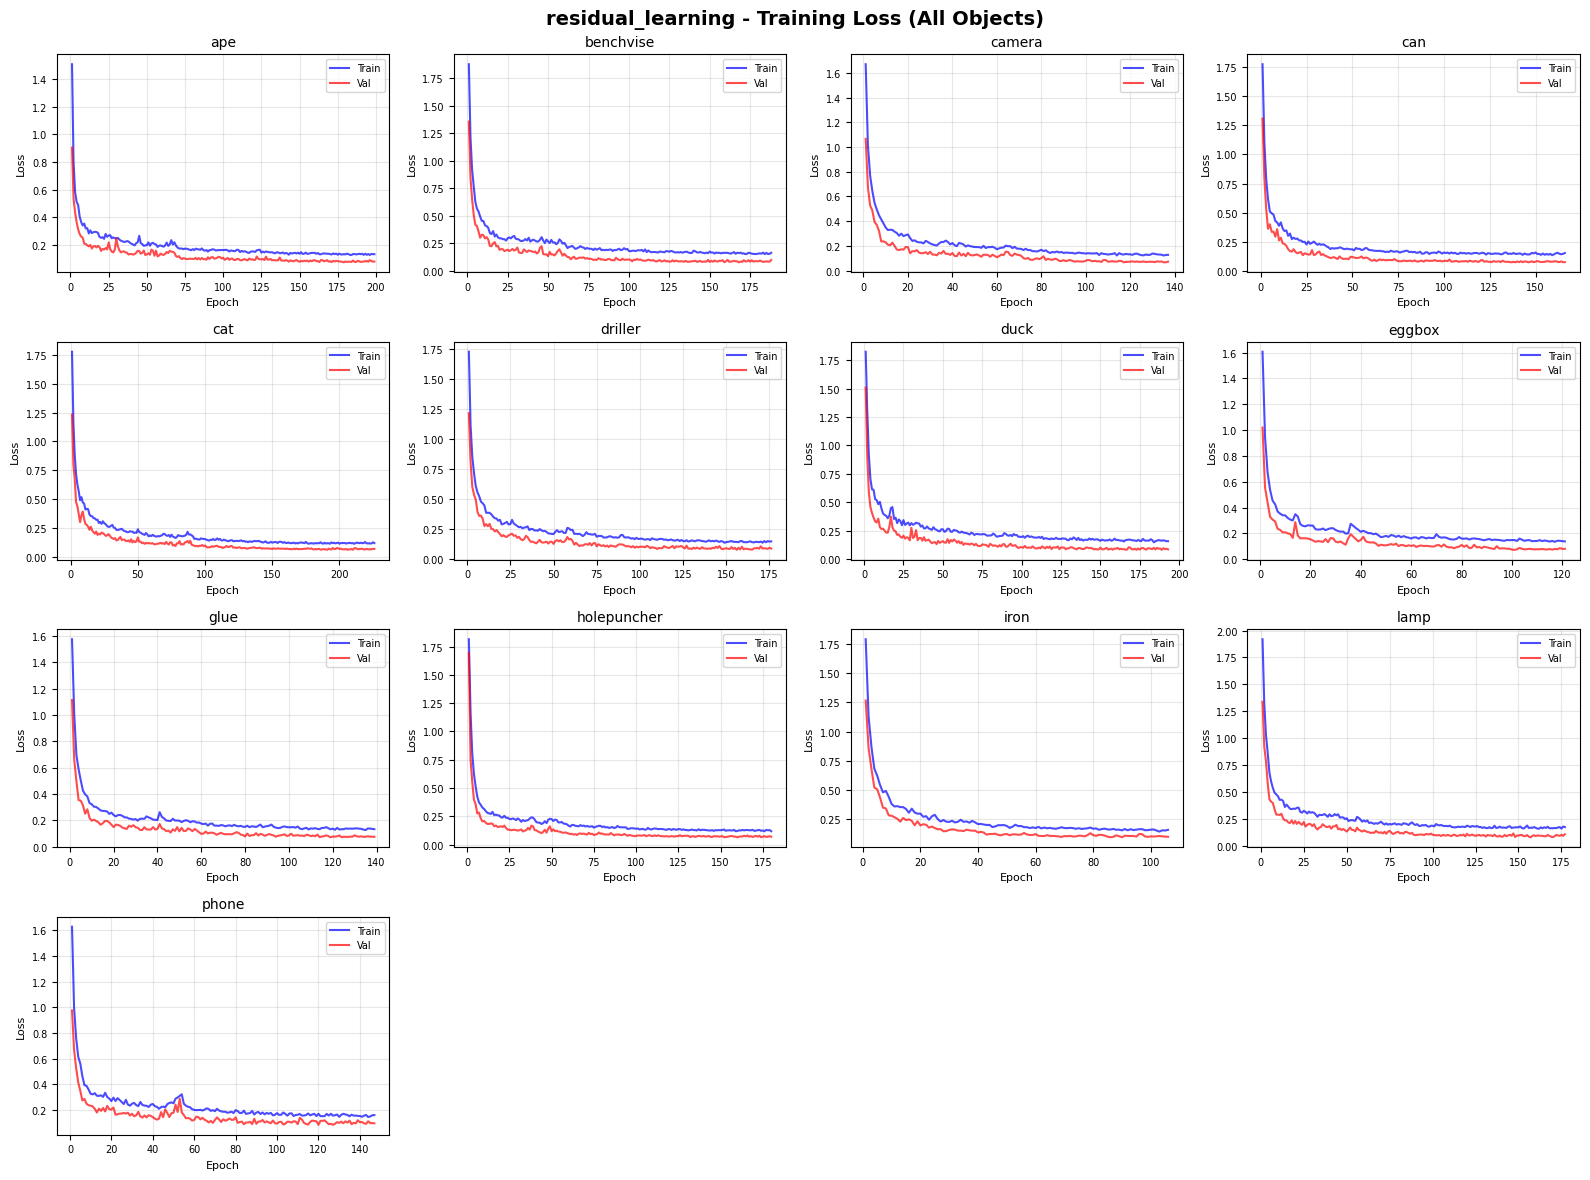

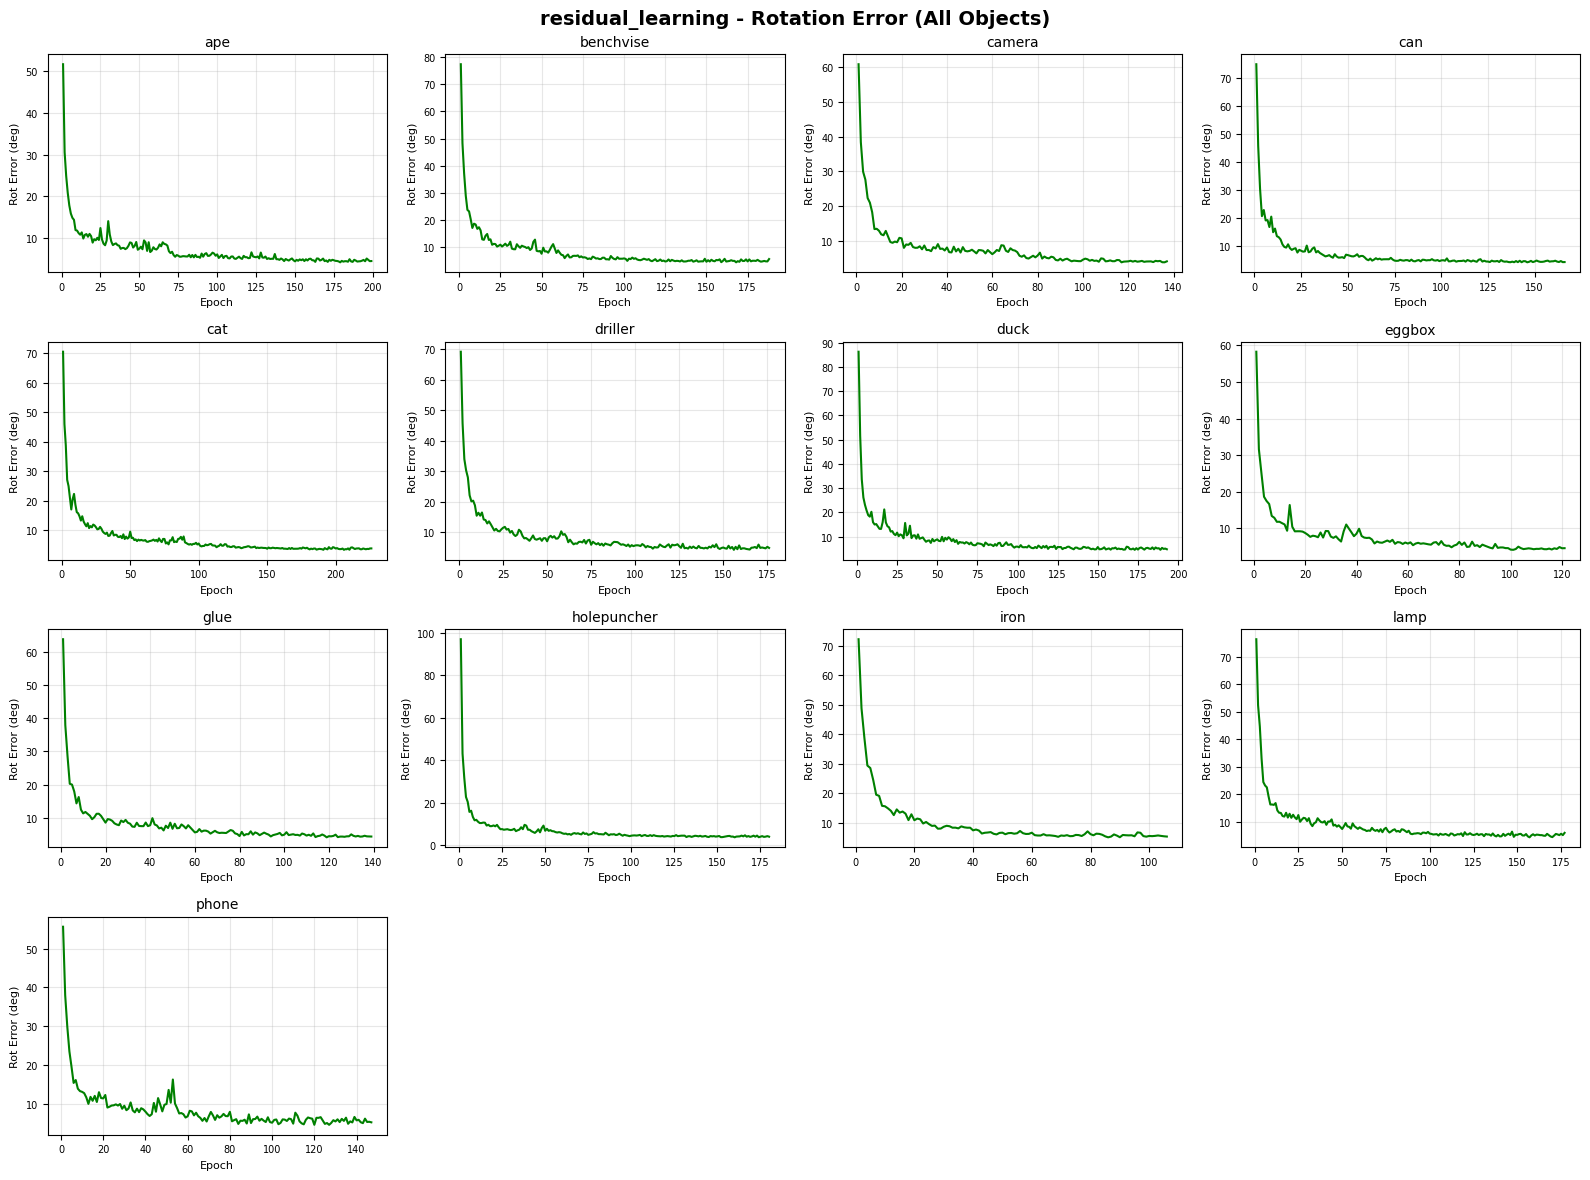

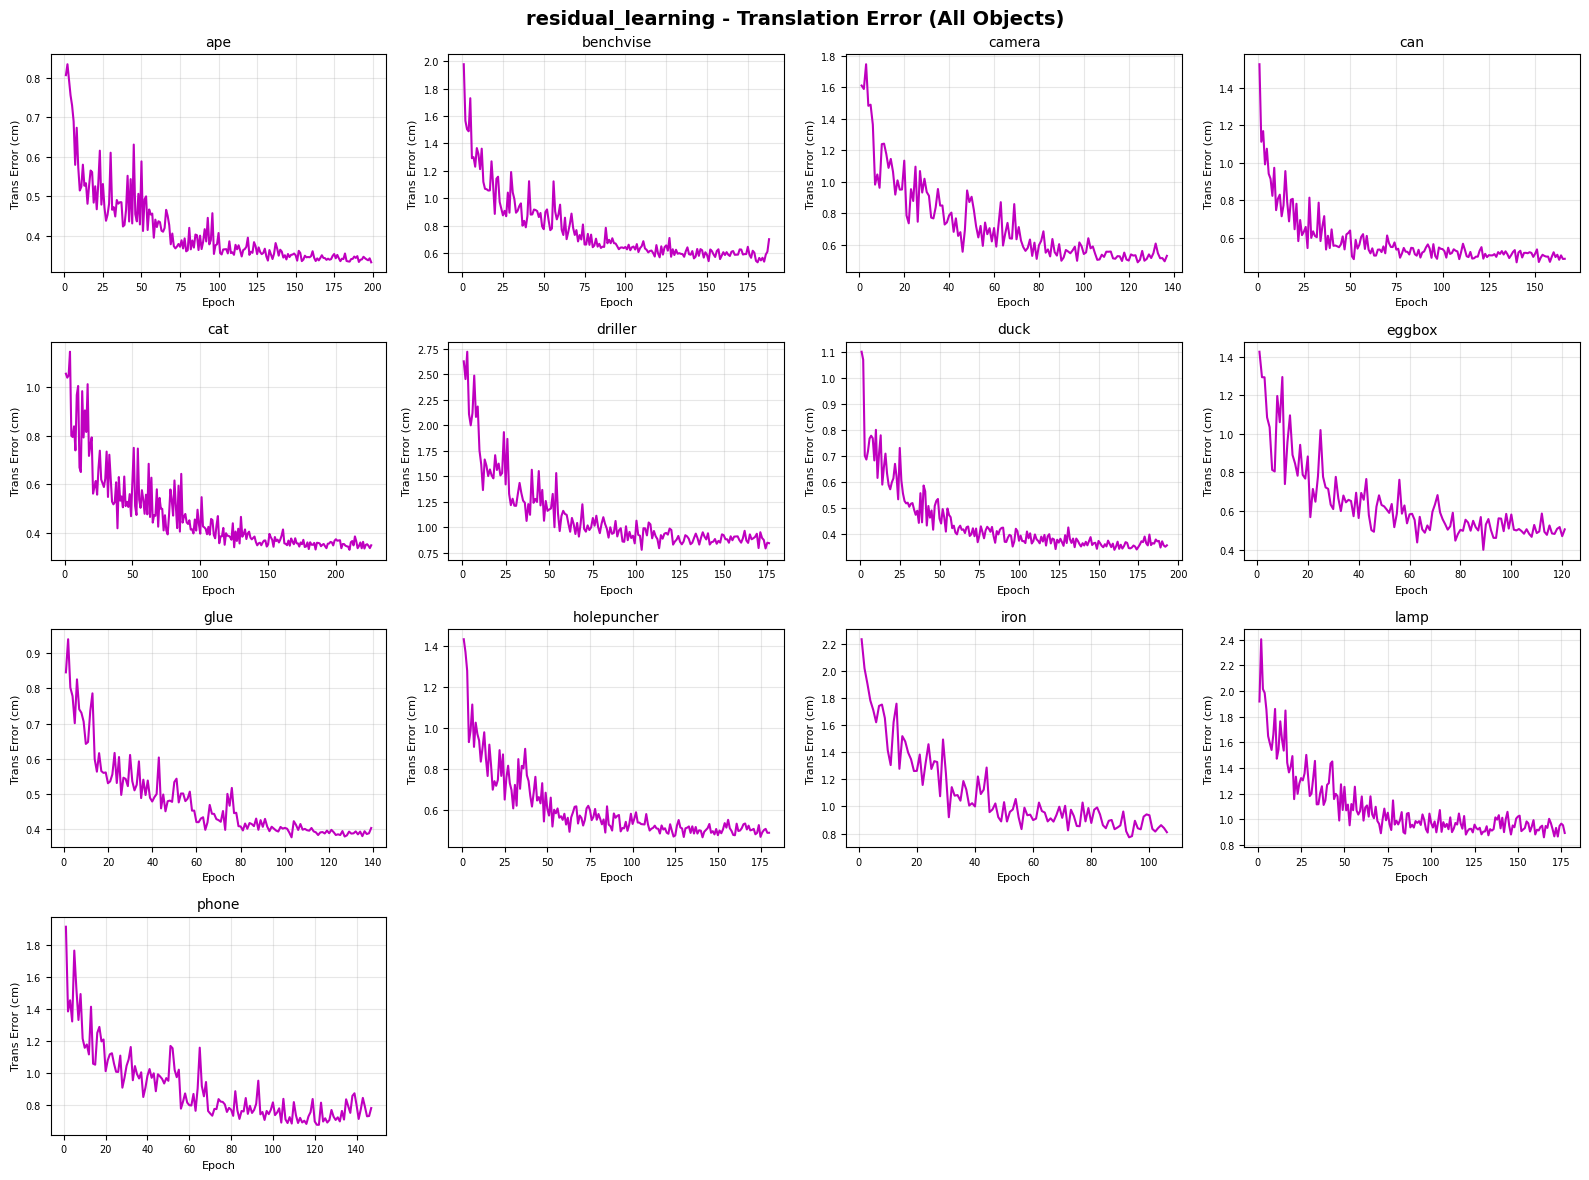


DENSEFUSION_ITERATIVE - Training Curves


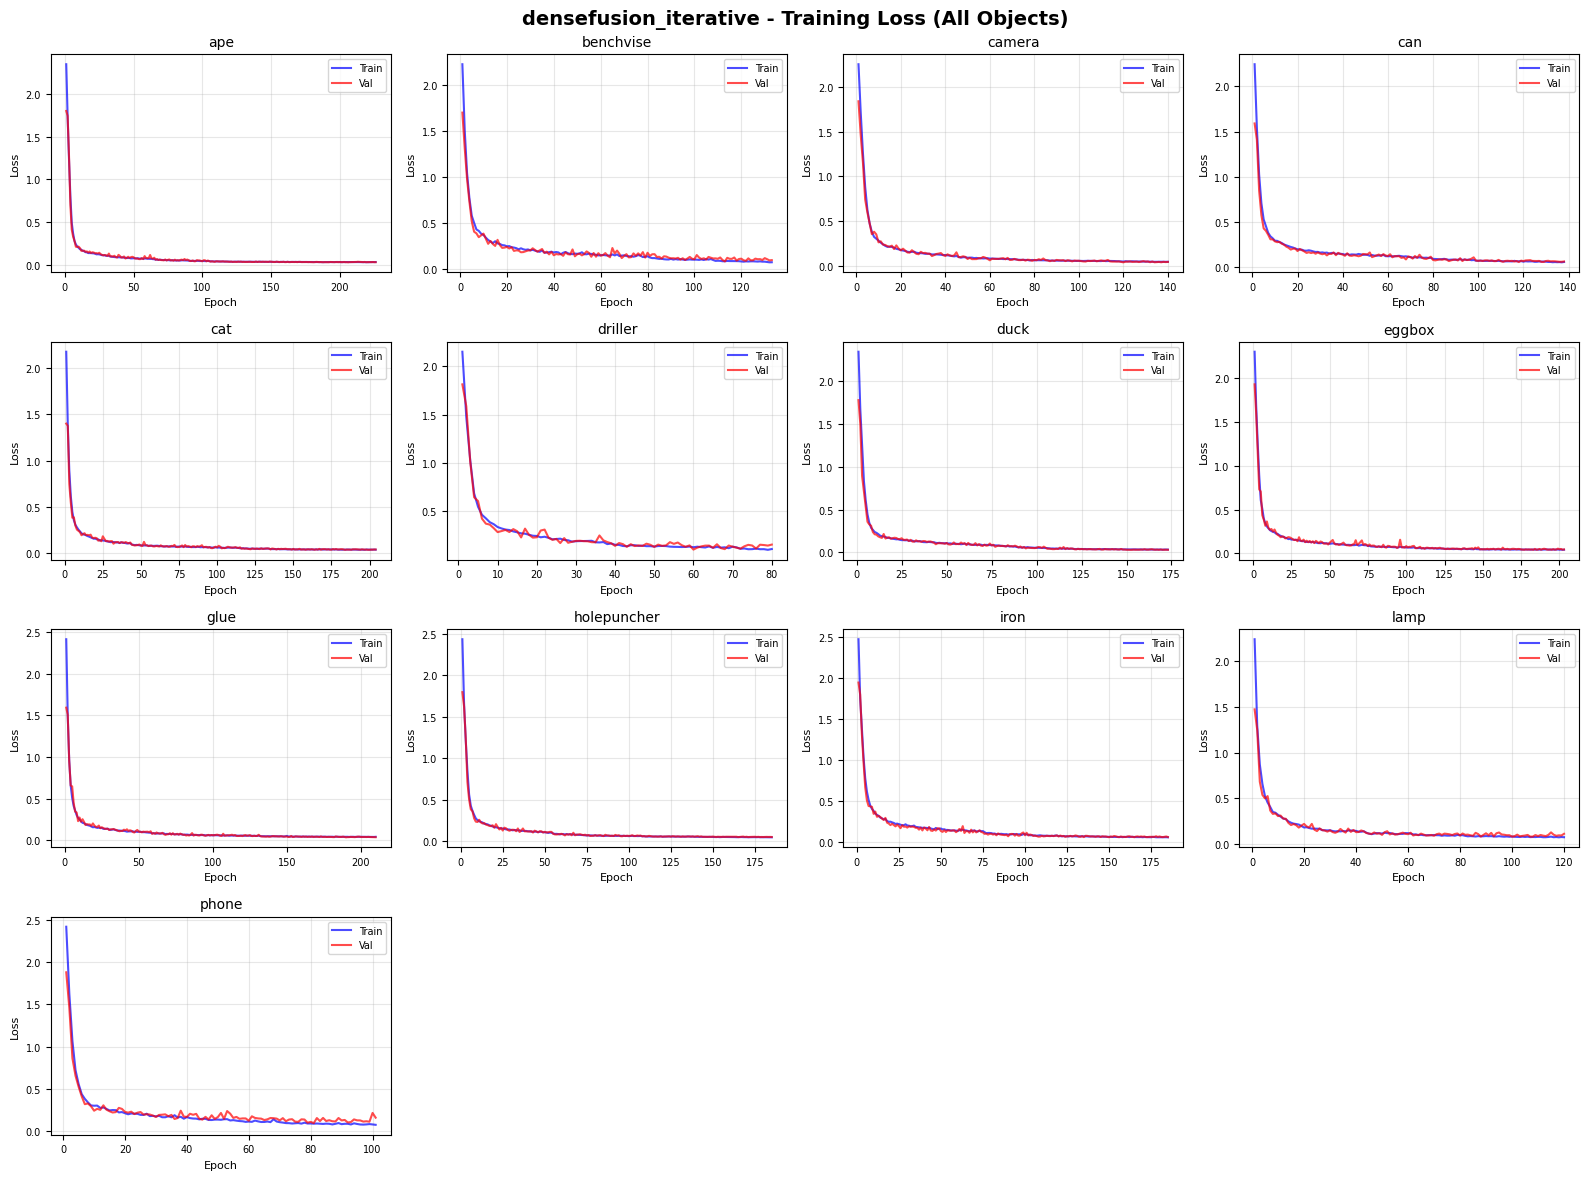

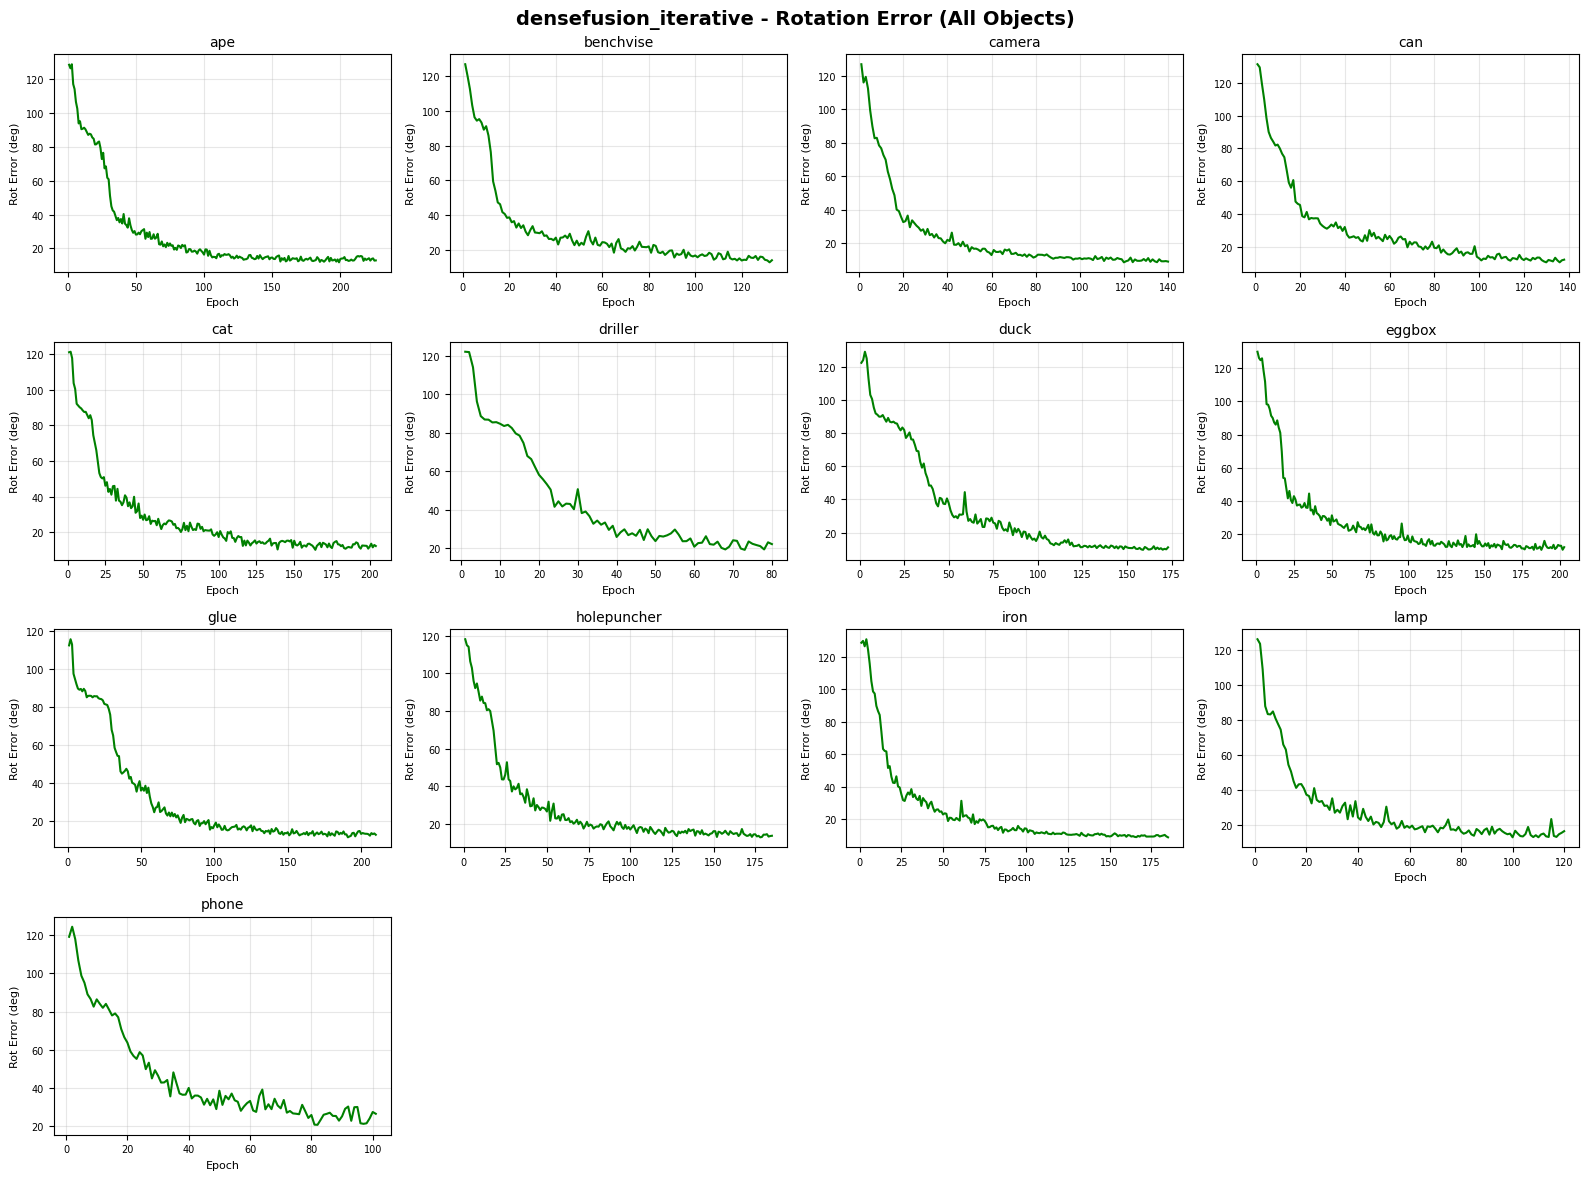

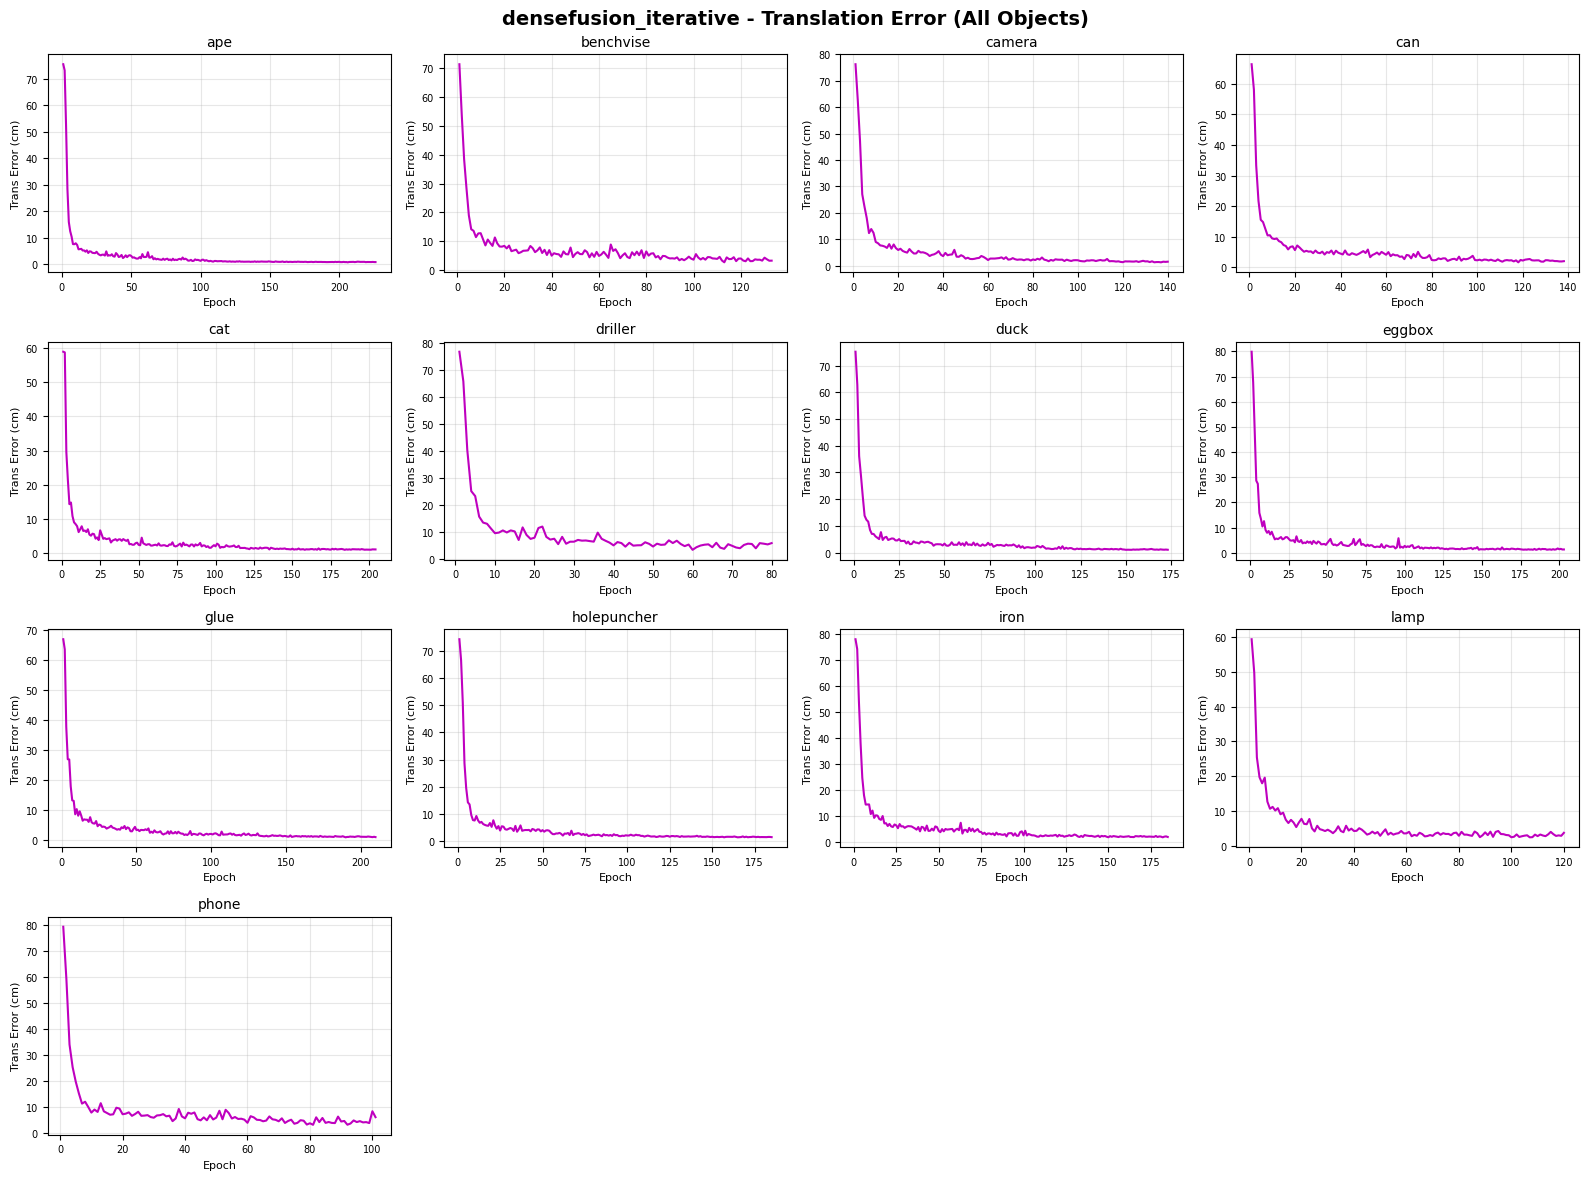


PVN3D - Training Curves


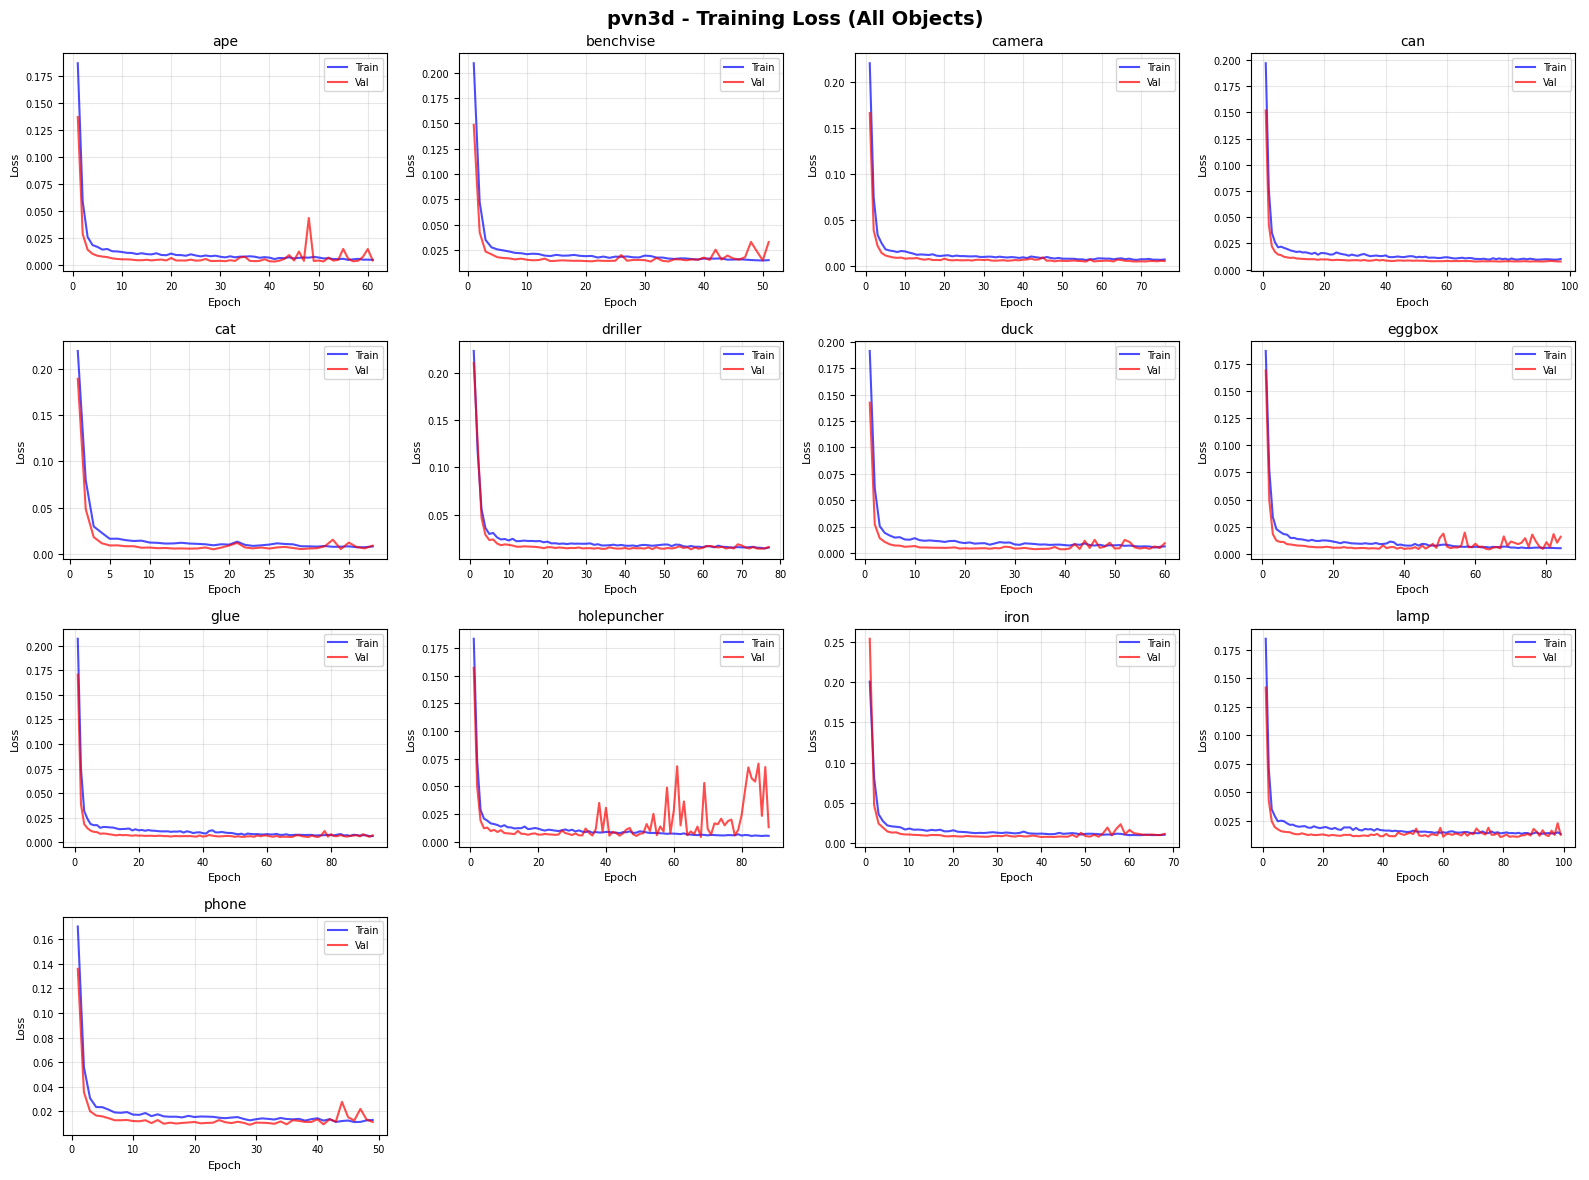

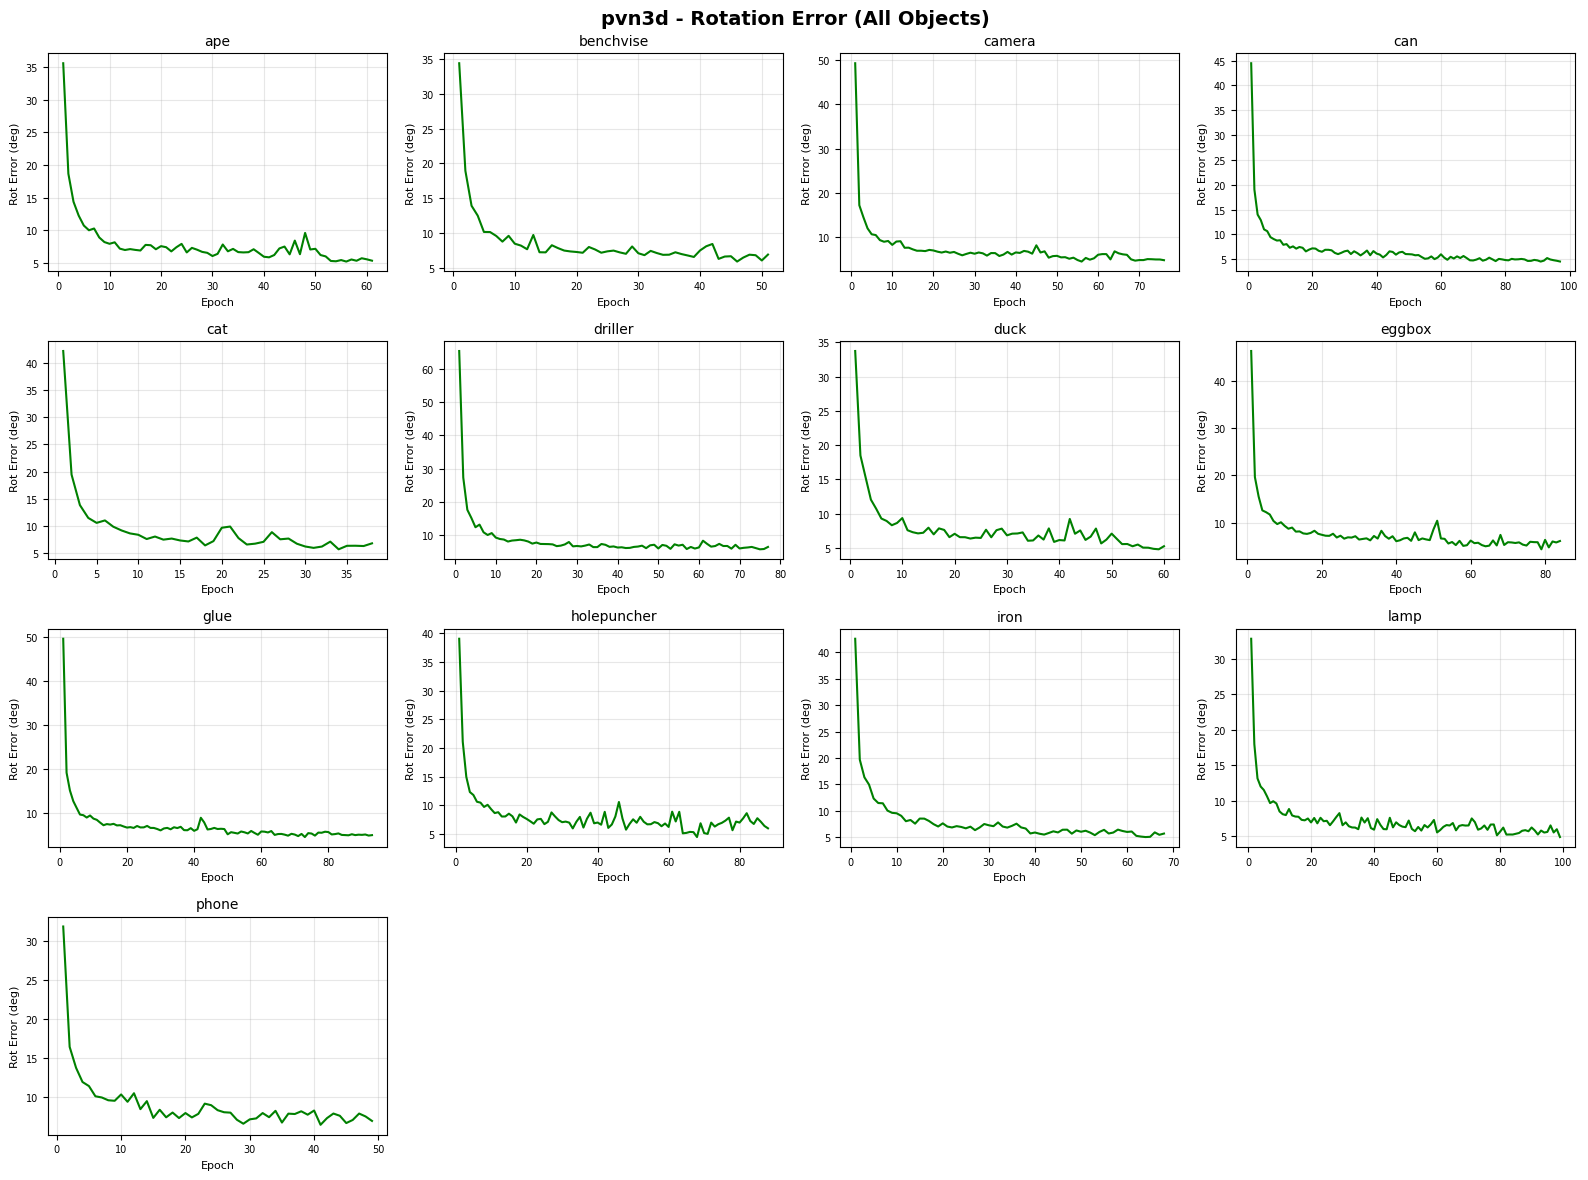

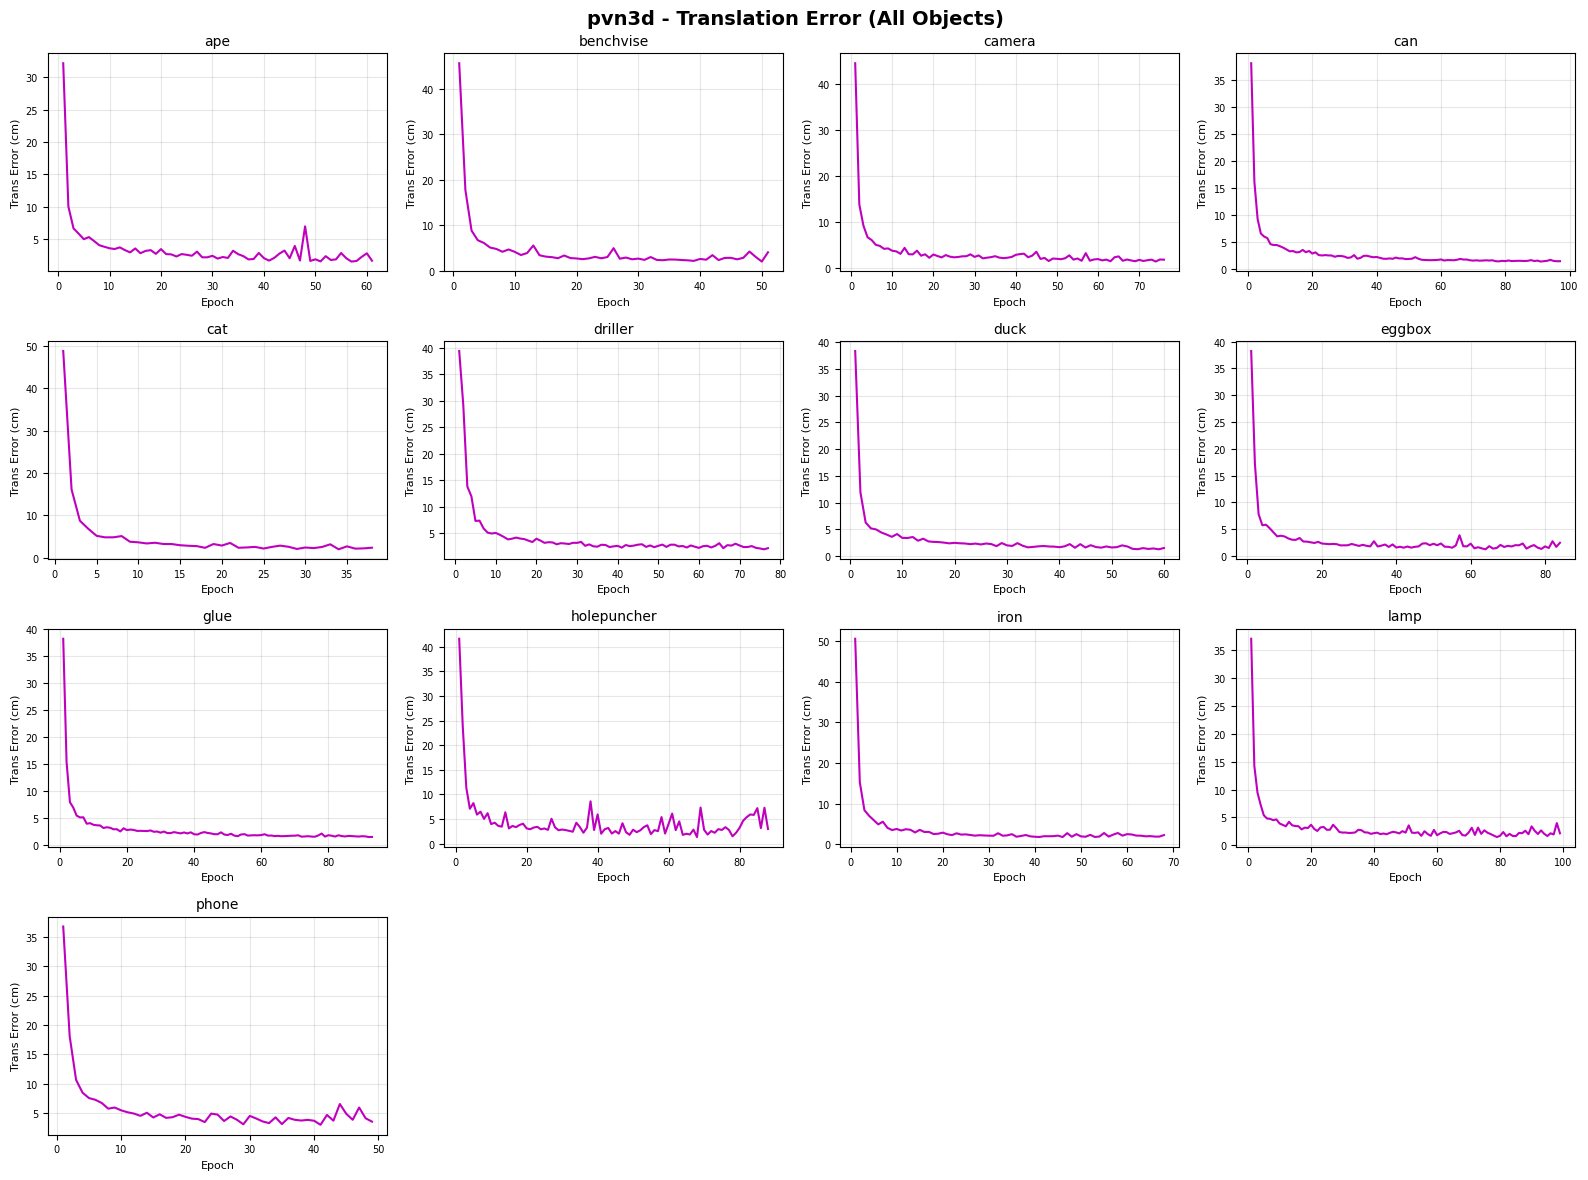


FFB6D - Training Curves


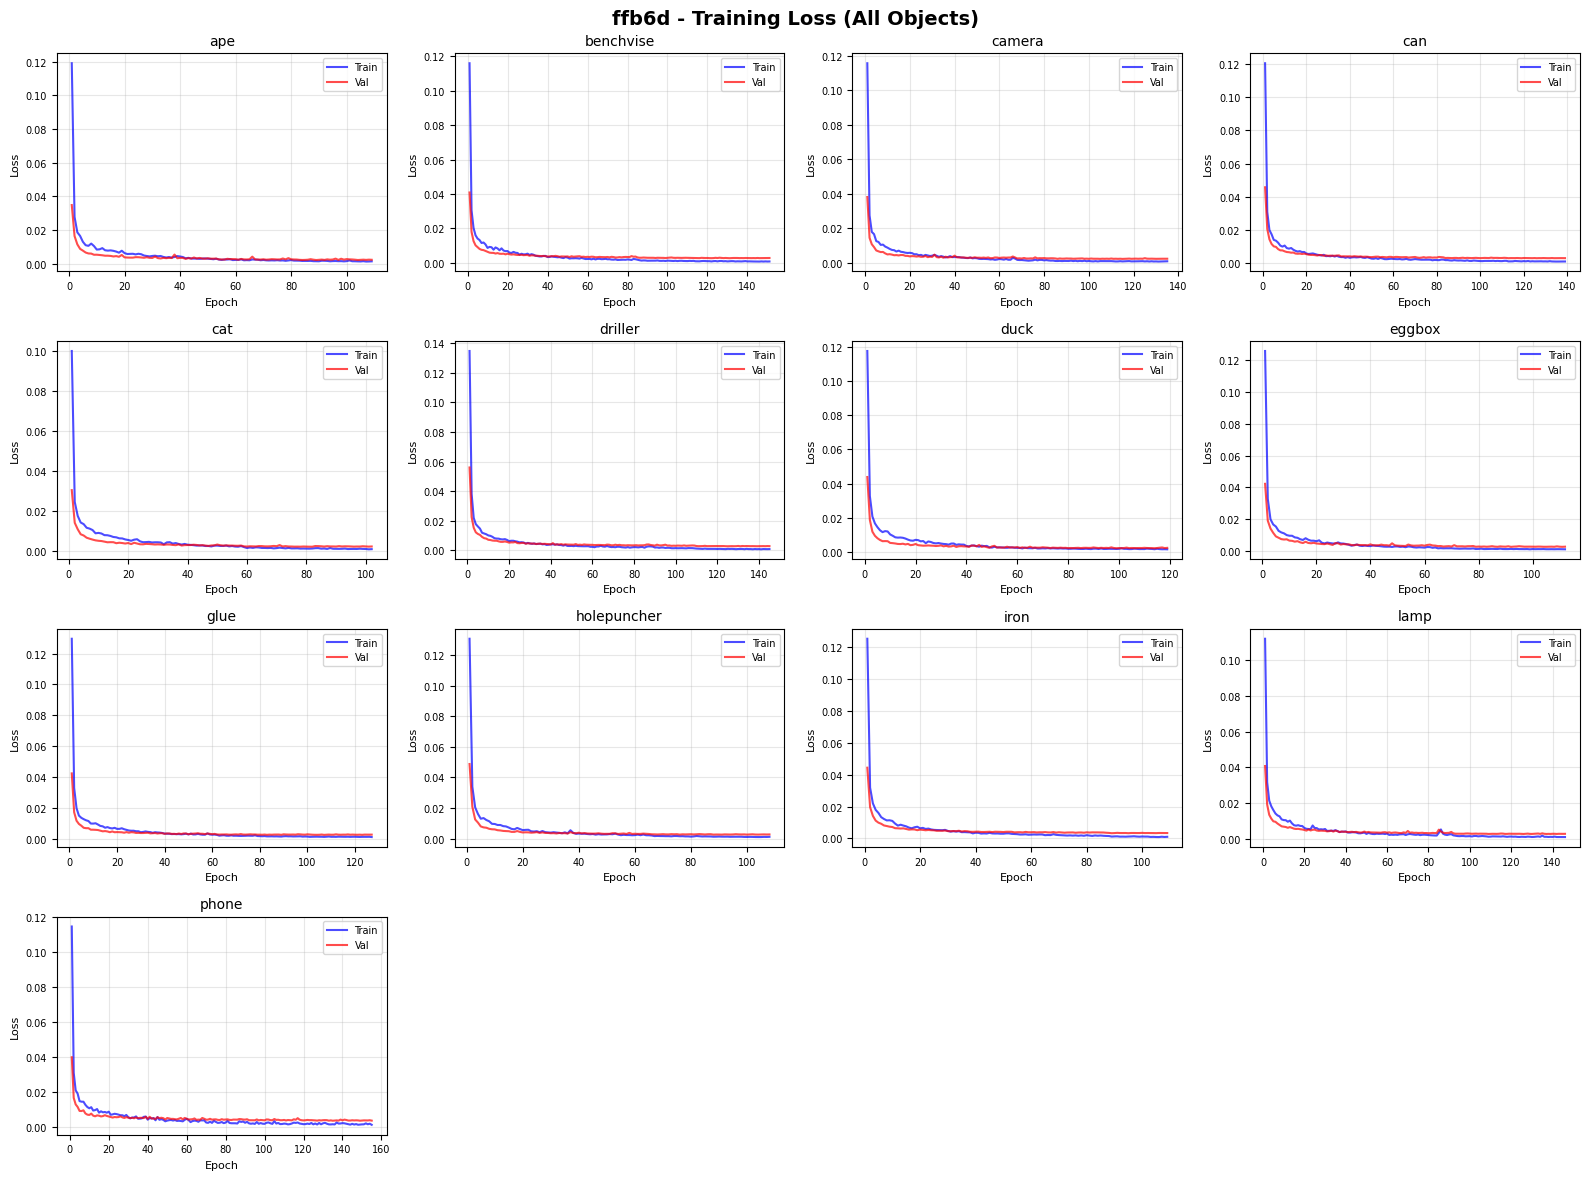

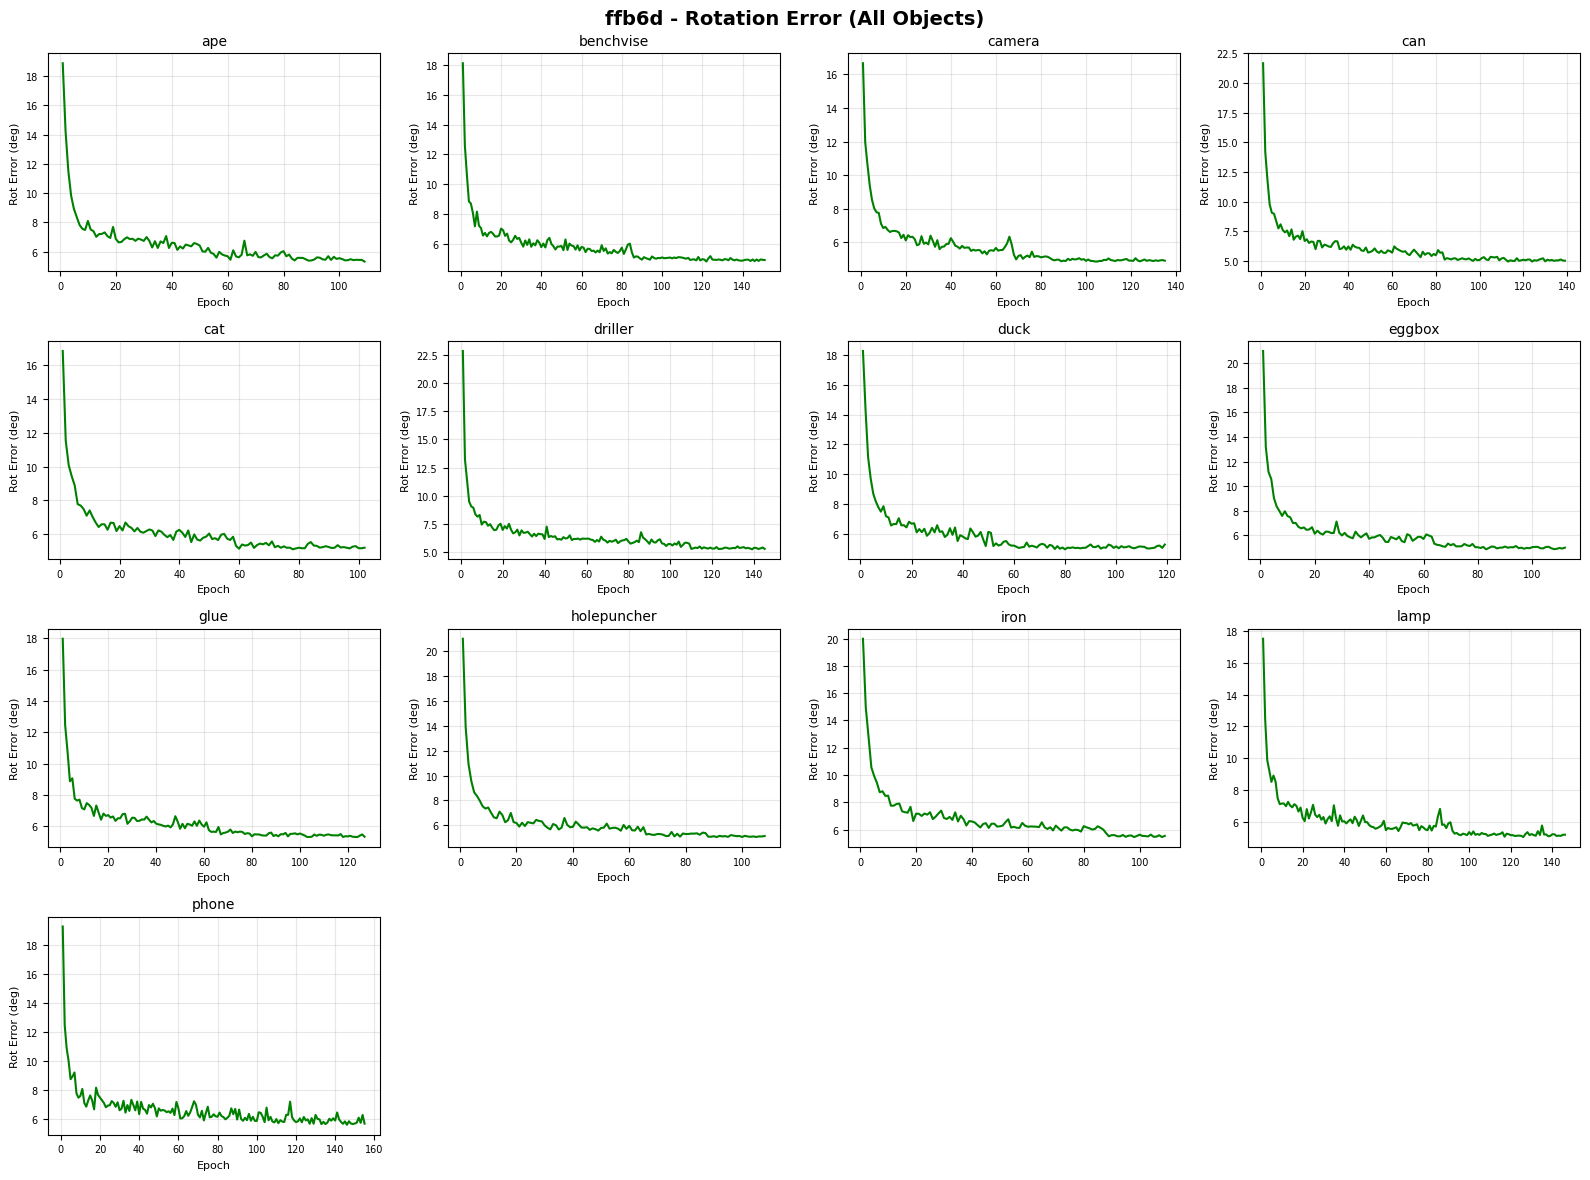

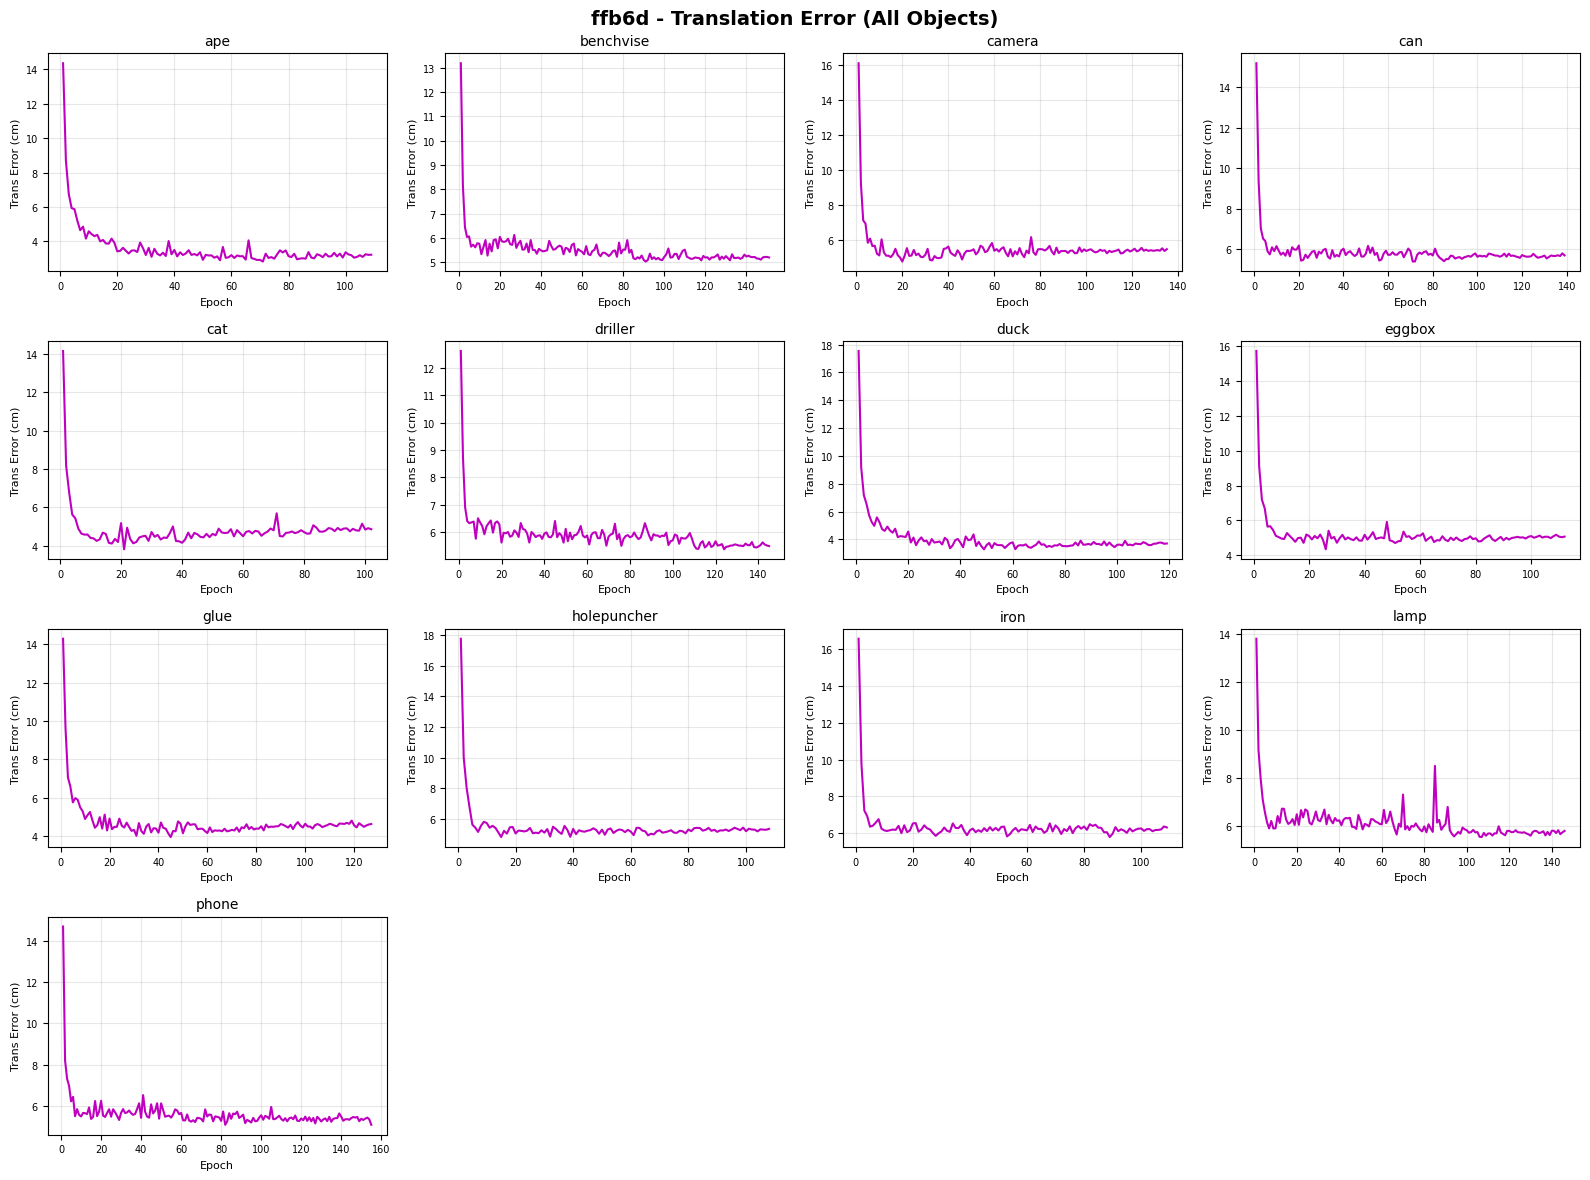

In [6]:
# Plot training curves for each RGBD model
for model_name in RGBD_MODELS:
    print(f"\n{model_name.upper()} - Training Curves")
    print("=" * 60)
    plot_training_curves_grid(model_name, 'rgbd')

## 3. Model Comparison - All Objects

In [7]:
def compare_models_all_objects(model_configs, metric='rot_err'):
    """
    Compare multiple models across all objects for a specific metric.
    
    Args:
        model_configs: List of tuples (model_name, pipeline_type)
        metric: 'val_loss', 'rot_err', or 'trans_err'
    """
    # Find objects that have data for at least one model
    available_objects = set()
    for model_name, pipeline_type in model_configs:
        for obj_name in ALL_OBJECTS:
            history = load_history(model_name, obj_name, pipeline_type)
            if history is not None:
                available_objects.add(obj_name)
    
    available_objects = sorted(list(available_objects))
    if not available_objects:
        print("No data available for comparison")
        return
    
    n_objects = len(available_objects)
    n_cols = min(4, n_objects)
    n_rows = (n_objects + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows))
    axes = np.array(axes).reshape(-1) if n_objects > 1 else [axes]
    
    metric_labels = {
        'val_loss': 'Validation Loss',
        'rot_err': 'Rotation Error (deg)',
        'trans_err': 'Translation Error (cm)'
    }
    
    for idx, obj_name in enumerate(available_objects):
        for model_name, pipeline_type in model_configs:
            history = load_history(model_name, obj_name, pipeline_type)
            if history is None:
                continue
            
            data = history.get(metric, [])
            if not data or (metric == 'trans_err' and not any(e > 0 for e in data)):
                continue
            
            epochs = range(1, len(data) + 1)
            label = 'RGB' if pipeline_type == 'rgb' else model_name
            axes[idx].plot(epochs, data, label=label, linewidth=1.5, alpha=0.8)
        
        axes[idx].set_title(obj_name, fontsize=10)
        axes[idx].set_xlabel('Epoch', fontsize=8)
        axes[idx].set_ylabel(metric_labels.get(metric, metric), fontsize=8)
        axes[idx].legend(fontsize=6, loc='best')
        axes[idx].grid(True, alpha=0.3)
        axes[idx].tick_params(labelsize=7)
    
    for idx in range(len(available_objects), len(axes)):
        axes[idx].set_visible(False)
    
    fig.suptitle(f'Model Comparison - {metric_labels.get(metric, metric)} (All Objects)', 
                 fontsize=14, fontweight='bold')
    fig.tight_layout()
    plt.show()

RGBD Models Comparison - Rotation Error


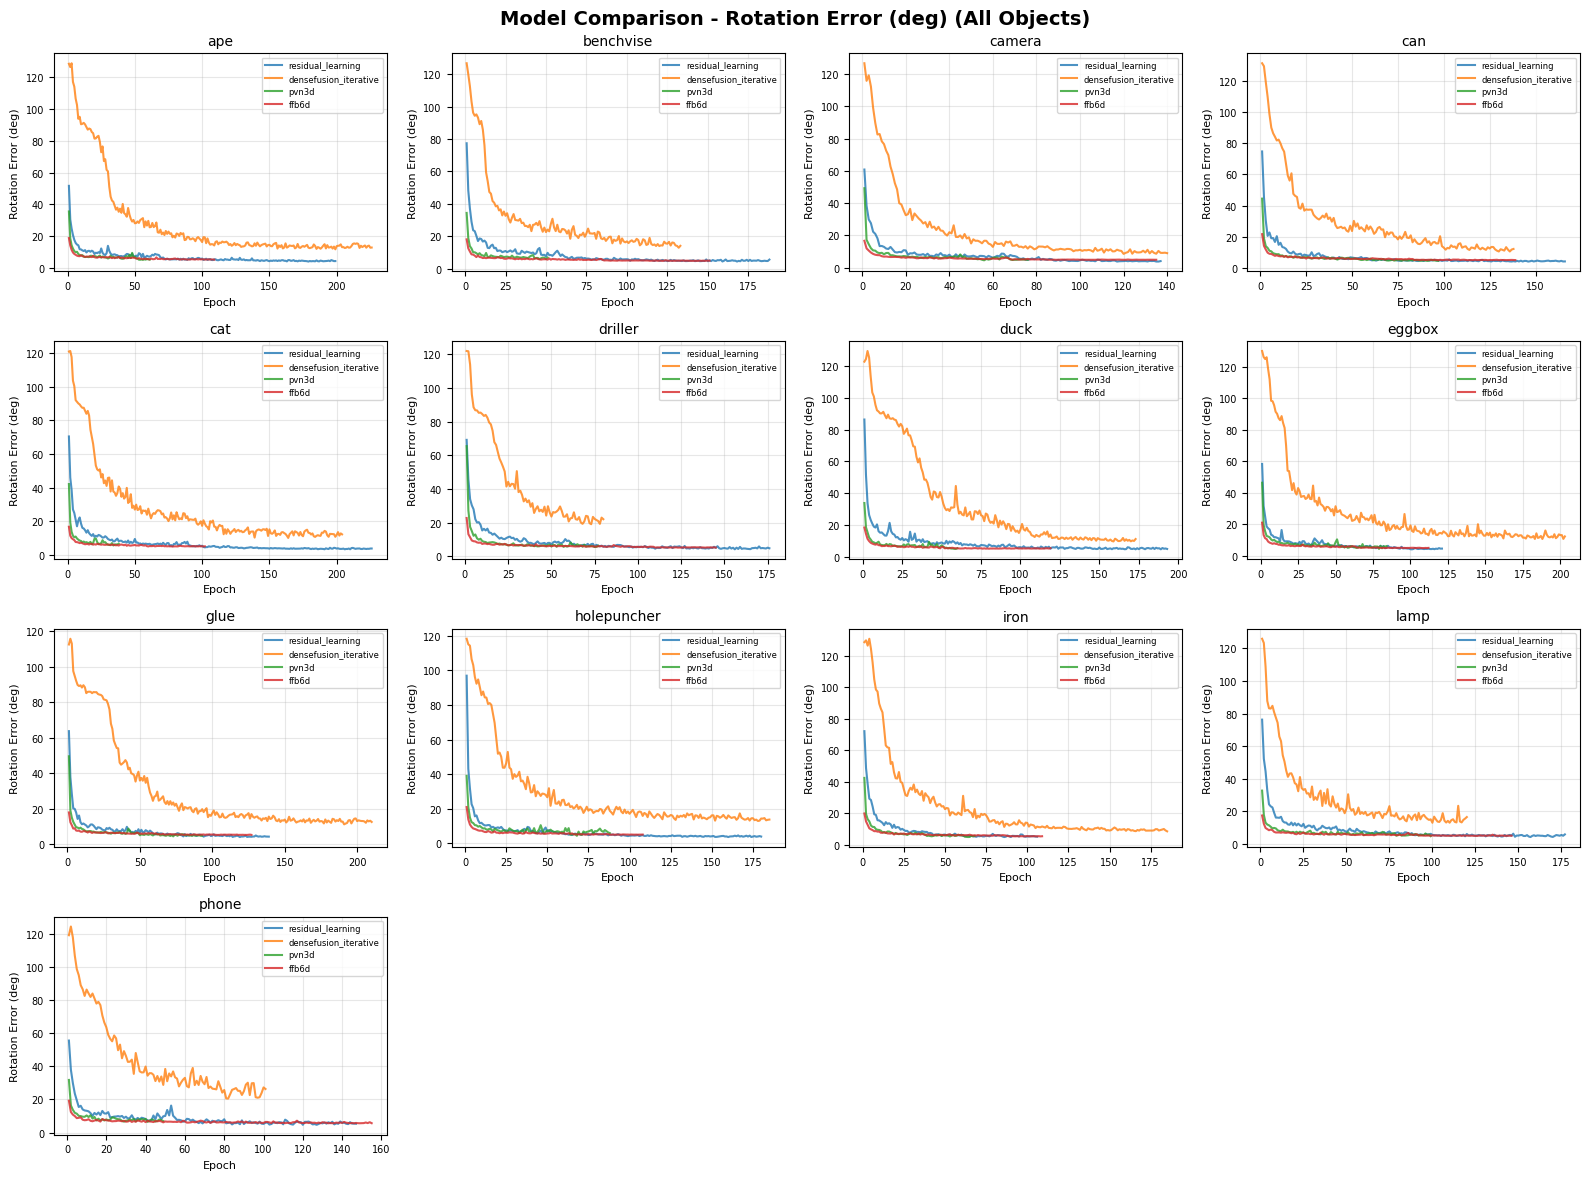

In [8]:
# Compare all RGBD models - Rotation Error
print("RGBD Models Comparison - Rotation Error")
print("=" * 60)
rgbd_configs = [(m, 'rgbd') for m in RGBD_MODELS]
compare_models_all_objects(rgbd_configs, metric='rot_err')

RGBD Models Comparison - Translation Error


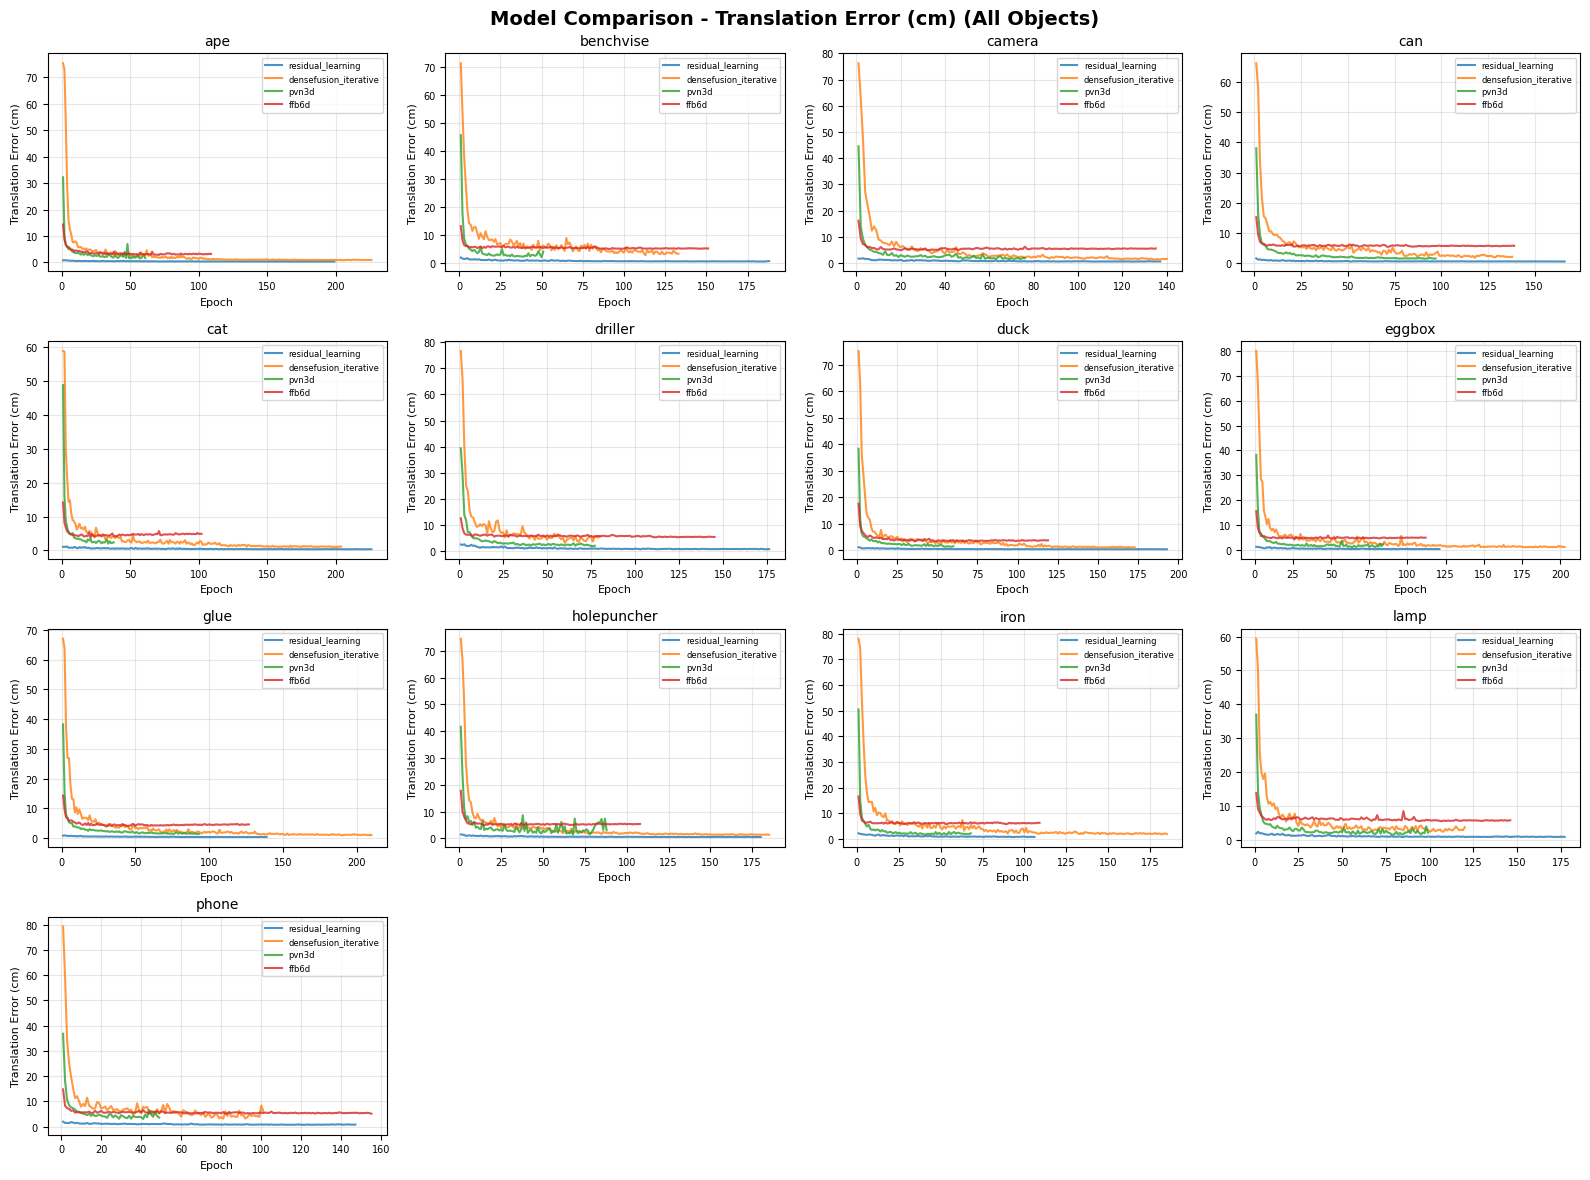

In [9]:
# Compare all RGBD models - Translation Error
print("RGBD Models Comparison - Translation Error")
print("=" * 60)
compare_models_all_objects(rgbd_configs, metric='trans_err')

RGB vs RGBD (Residual Learning) Comparison


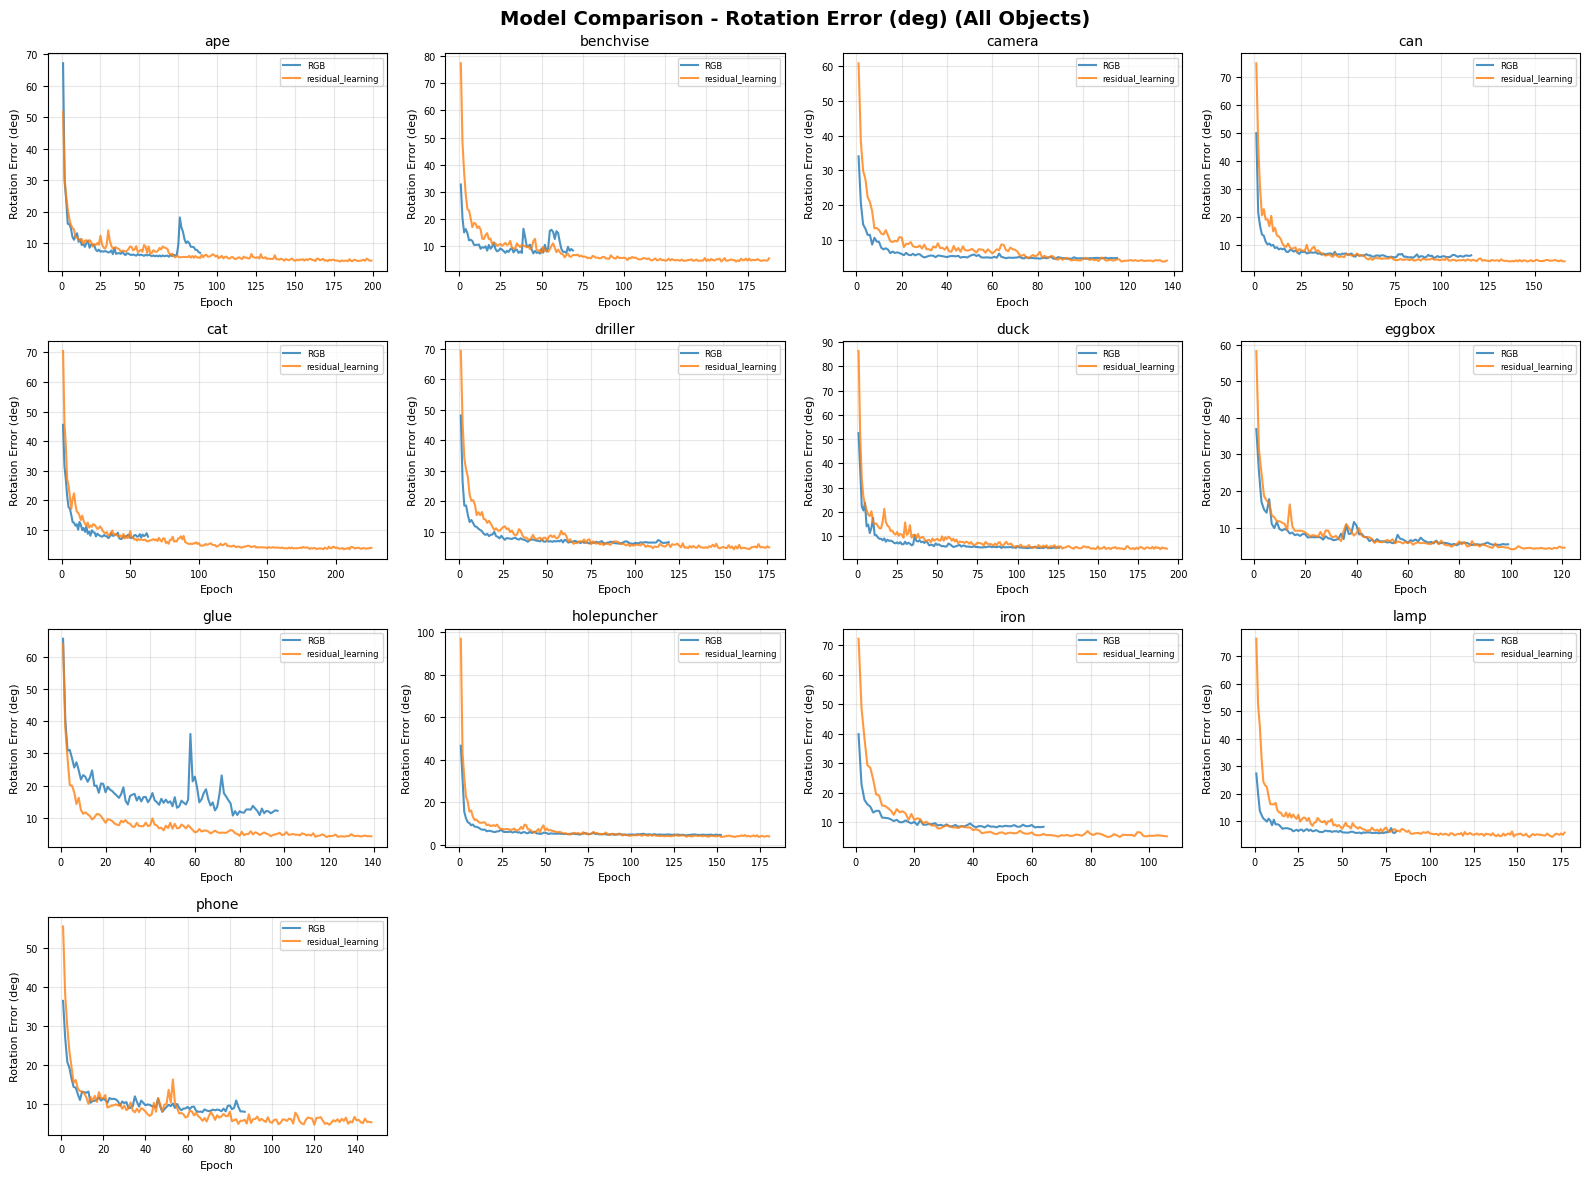

In [10]:
# Compare RGB vs best RGBD model (residual_learning)
print("RGB vs RGBD (Residual Learning) Comparison")
print("=" * 60)
rgb_vs_rgbd = [('rgb', 'rgb'), ('residual_learning', 'rgbd')]
compare_models_all_objects(rgb_vs_rgbd, metric='rot_err')

RGB vs RGBD (Residual Learning) - Translation Error


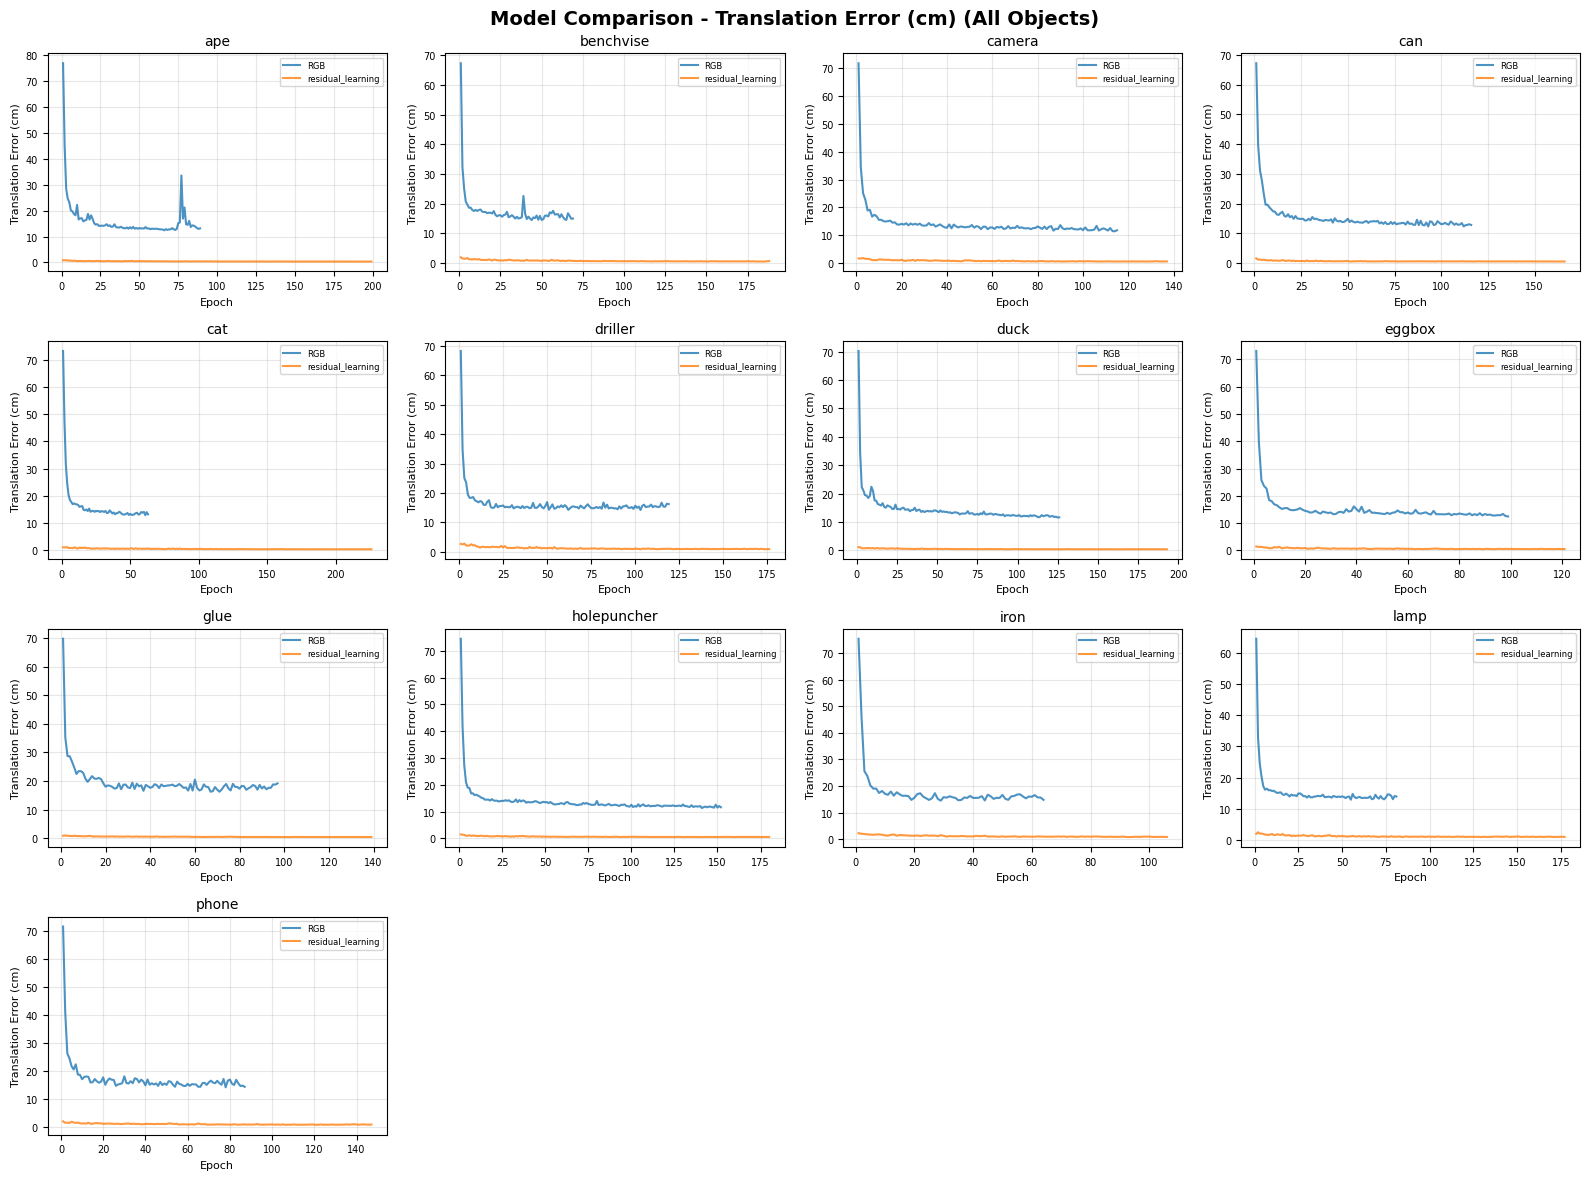

In [11]:
# Compare RGB vs RGBD - Translation Error
print("RGB vs RGBD (Residual Learning) - Translation Error")
print("=" * 60)
compare_models_all_objects(rgb_vs_rgbd, metric='trans_err')

## 4. Results Summary Tables

In [12]:
def create_results_table(objects, pipelines):
    """
    Create a comprehensive results table for all objects and pipelines.
    
    Args:
        objects: List of object names
        pipelines: List of tuples (model_name, pipeline_type)
    
    Returns:
        DataFrame with results
    """
    results = []
    
    for obj in objects:
        for model_name, pipeline_type in pipelines:
            history = load_history(model_name, obj, pipeline_type)
            if history is None:
                continue
            
            val_loss = history['val_loss']
            rot_err = history['rot_err']
            trans_err = history['trans_err']
            
            if not val_loss:
                continue
            
            best_epoch = np.argmin(val_loss)
            best_loss = val_loss[best_epoch]
            best_rot_err = rot_err[best_epoch] if rot_err else None
            best_trans_err = trans_err[best_epoch] if trans_err and any(e > 0 for e in trans_err) else None
            
            # Final values (last epoch)
            final_rot_err = rot_err[-1] if rot_err else None
            final_trans_err = trans_err[-1] if trans_err and any(e > 0 for e in trans_err) else None
            
            # Display name
            display_name = model_name if pipeline_type == 'rgbd' else 'RGB (6D Pose)'
            
            results.append({
                'Object': obj,
                'Pipeline': display_name,
                'Type': pipeline_type.upper(),
                'Best Loss': best_loss,
                'Best Rot (deg)': best_rot_err,
                'Best Trans (cm)': best_trans_err,
                'Final Rot (deg)': final_rot_err,
                'Final Trans (cm)': final_trans_err,
                'Epochs': len(val_loss)
            })
    
    if not results:
        print("Warning: No results found. Train models first.")
        return None
    
    return pd.DataFrame(results)


def create_summary_by_model(df):
    """
    Create summary statistics grouped by model/pipeline.
    
    Args:
        df: Results DataFrame
    
    Returns:
        Summary DataFrame
    """
    if df is None:
        return None
    
    summary = df.groupby('Pipeline').agg({
        'Best Rot (deg)': ['mean', 'std', 'min', 'max'],
        'Best Trans (cm)': ['mean', 'std', 'min', 'max'],
        'Object': 'count'
    }).round(2)
    
    summary.columns = ['Rot Mean', 'Rot Std', 'Rot Min', 'Rot Max',
                       'Trans Mean', 'Trans Std', 'Trans Min', 'Trans Max',
                       'Num Objects']
    
    return summary.reset_index()

In [13]:
# Create comprehensive results table
results_df = create_results_table(ALL_OBJECTS, ALL_PIPELINES)

if results_df is not None:
    print("Complete Training Results - All Objects")
    print("=" * 120)
    
    # Format numeric columns for display
    display_df = results_df.copy()
    for col in ['Best Loss', 'Best Rot (deg)', 'Best Trans (cm)', 'Final Rot (deg)', 'Final Trans (cm)']:
        display_df[col] = display_df[col].apply(lambda x: f"{x:.2f}" if pd.notna(x) else 'N/A')
    
    print(display_df.to_string(index=False))
    print("=" * 120)

Complete Training Results - All Objects
     Object              Pipeline Type Best Loss Best Rot (deg) Best Trans (cm) Final Rot (deg) Final Trans (cm)  Epochs
        ape         RGB (6D Pose)  RGB      0.50           5.66           12.76            6.87            13.14      89
        ape     residual_learning RGBD      0.07           4.13            0.34            4.43             0.33     199
        ape densefusion_iterative RGBD      0.03          12.63            0.80           12.94             0.88     226
        ape                 pvn3d RGBD      0.00           5.86            1.69            5.34             1.67      61
        ape                 ffb6d RGBD      0.00           5.38            3.02            5.32             3.23     109
  benchvise         RGB (6D Pose)  RGB      0.65           7.35           15.91            8.48            15.01      69
  benchvise     residual_learning RGBD      0.08           4.41            0.59            5.62             0.70 

In [14]:
# Create summary by model
if results_df is not None:
    summary_df = create_summary_by_model(results_df)
    
    print("\nSummary Statistics by Model")
    print("=" * 100)
    print(summary_df.to_string(index=False))
    print("=" * 100)


Summary Statistics by Model
             Pipeline  Rot Mean  Rot Std  Rot Min  Rot Max  Trans Mean  Trans Std  Trans Min  Trans Max  Num Objects
        RGB (6D Pose)      6.40     1.80     4.48    10.75       14.02       1.94      12.07      18.98           13
densefusion_iterative     13.33     3.86     8.56    20.79        1.75       0.87       0.80       3.22           13
                ffb6d      5.20     0.23     4.92     5.66        4.92       0.84       3.02       5.78           13
                pvn3d      5.50     0.85     4.44     6.81        1.85       0.54       1.23       3.07           13
    residual_learning      4.20     0.43     3.44     5.02        0.57       0.21       0.34       0.91           13


## 5. Visualizations - Bar Charts

In [15]:
def plot_best_errors_by_object(df, metric='Best Rot (deg)'):
    """
    Plot best errors per object for each pipeline.
    
    Args:
        df: Results DataFrame
        metric: Column name to plot
    """
    if df is None:
        print("No data to plot")
        return
    
    # Pivot data for grouped bar chart
    pivot_df = df.pivot(index='Object', columns='Pipeline', values=metric)
    
    # Plot
    fig, ax = plt.subplots(figsize=(14, 6))
    
    x = np.arange(len(pivot_df.index))
    width = 0.15
    n_pipelines = len(pivot_df.columns)
    
    colors = plt.cm.Set2(np.linspace(0, 1, n_pipelines))
    
    for i, (pipeline, color) in enumerate(zip(pivot_df.columns, colors)):
        values = pivot_df[pipeline].values
        offset = (i - n_pipelines / 2 + 0.5) * width
        bars = ax.bar(x + offset, values, width, label=pipeline, color=color, edgecolor='black', alpha=0.8)
    
    ax.set_xlabel('Object', fontsize=12)
    ax.set_ylabel(metric, fontsize=12)
    ax.set_title(f'{metric} by Object and Pipeline', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(pivot_df.index, rotation=45, ha='right')
    ax.legend(loc='upper right', fontsize=9)
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()

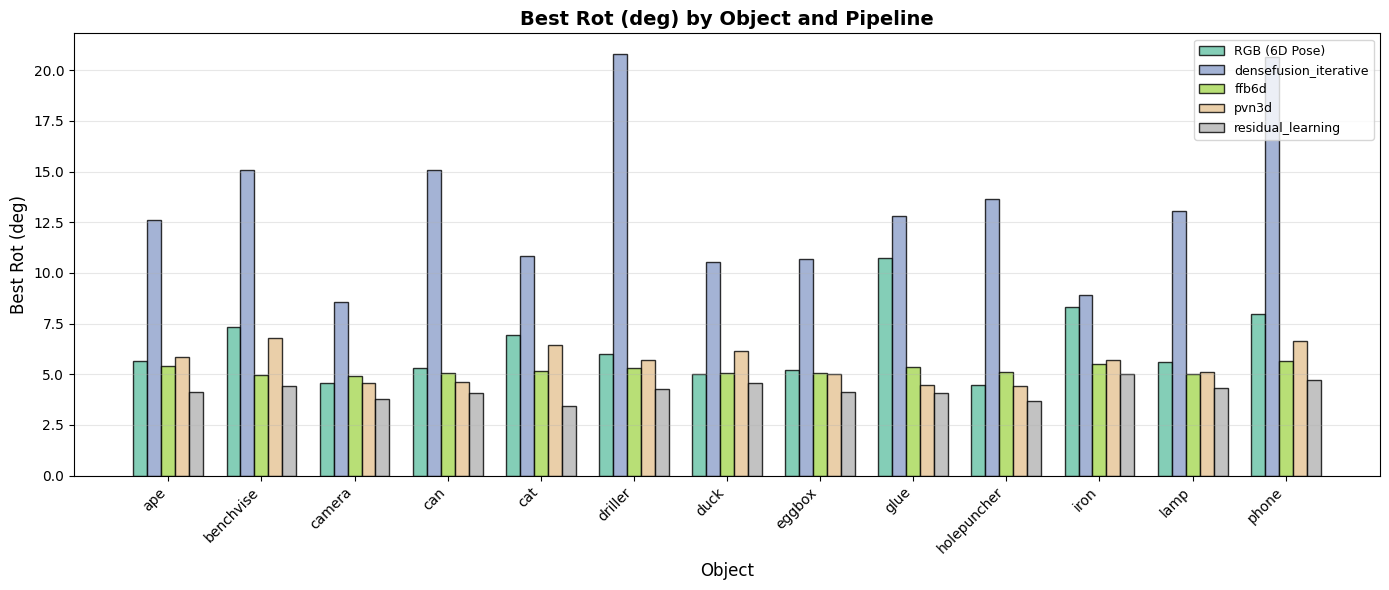

In [16]:
# Plot rotation errors by object
if results_df is not None:
    plot_best_errors_by_object(results_df, 'Best Rot (deg)')

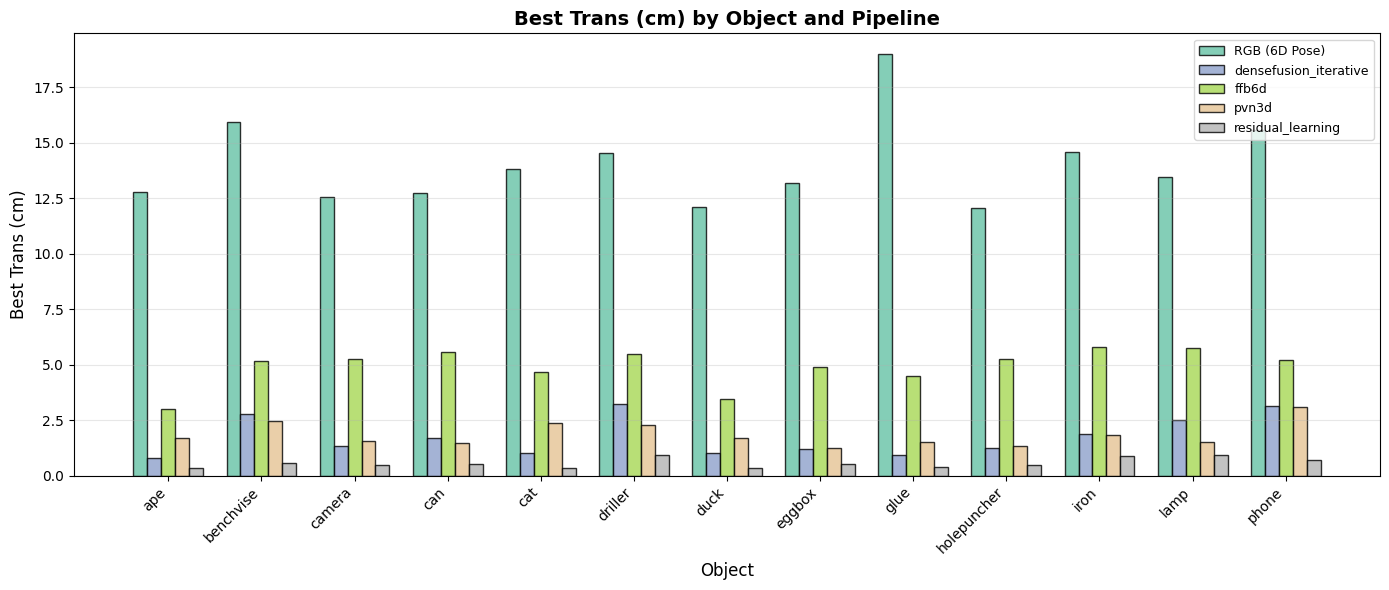

In [17]:
# Plot translation errors by object
if results_df is not None:
    plot_best_errors_by_object(results_df, 'Best Trans (cm)')

In [18]:
def plot_model_summary(summary_df):
    """
    Plot summary statistics for all models.
    
    Args:
        summary_df: Summary DataFrame from create_summary_by_model
    """
    if summary_df is None:
        print("No summary data to plot")
        return
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    pipelines = summary_df['Pipeline'].values
    x = np.arange(len(pipelines))
    
    # Rotation error
    rot_mean = summary_df['Rot Mean'].values
    rot_std = summary_df['Rot Std'].values
    
    colors = plt.cm.Blues(np.linspace(0.4, 0.9, len(pipelines)))
    bars1 = axes[0].bar(x, rot_mean, yerr=rot_std, capsize=5, color=colors, edgecolor='black')
    axes[0].set_xlabel('Pipeline', fontsize=12)
    axes[0].set_ylabel('Rotation Error (deg)', fontsize=12)
    axes[0].set_title('Mean Rotation Error by Model', fontsize=14, fontweight='bold')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(pipelines, rotation=45, ha='right')
    axes[0].grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for bar, val in zip(bars1, rot_mean):
        if not np.isnan(val):
            axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                        f'{val:.1f}', ha='center', va='bottom', fontsize=9)
    
    # Translation error
    trans_mean = summary_df['Trans Mean'].values
    trans_std = summary_df['Trans Std'].values
    
    # Handle NaN values
    trans_mean_plot = np.nan_to_num(trans_mean, nan=0)
    trans_std_plot = np.nan_to_num(trans_std, nan=0)
    
    colors = plt.cm.Oranges(np.linspace(0.4, 0.9, len(pipelines)))
    bars2 = axes[1].bar(x, trans_mean_plot, yerr=trans_std_plot, capsize=5, color=colors, edgecolor='black')
    axes[1].set_xlabel('Pipeline', fontsize=12)
    axes[1].set_ylabel('Translation Error (cm)', fontsize=12)
    axes[1].set_title('Mean Translation Error by Model', fontsize=14, fontweight='bold')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(pipelines, rotation=45, ha='right')
    axes[1].grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for bar, val in zip(bars2, trans_mean):
        if not np.isnan(val) and val > 0:
            axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                        f'{val:.1f}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()

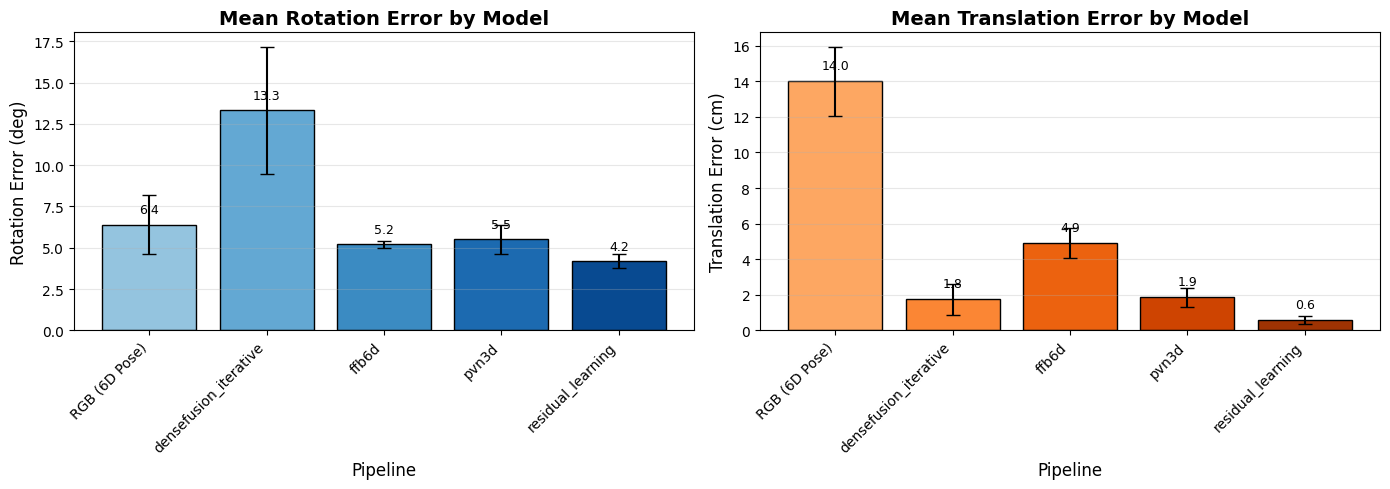

In [19]:
# Plot model summary
if results_df is not None:
    summary_df = create_summary_by_model(results_df)
    plot_model_summary(summary_df)

## 6. Heatmap Visualization

In [20]:
def plot_error_heatmap(df, metric='Best Rot (deg)'):
    """
    Plot heatmap of errors across objects and pipelines.
    
    Args:
        df: Results DataFrame
        metric: Column name to plot
    """
    if df is None:
        print("No data to plot")
        return
    
    # Pivot data
    pivot_df = df.pivot(index='Object', columns='Pipeline', values=metric)
    
    # Plot heatmap
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Use appropriate colormap
    cmap = 'YlOrRd'  # Yellow to Red (lower is better)
    
    im = ax.imshow(pivot_df.values, cmap=cmap, aspect='auto')
    
    # Set ticks
    ax.set_xticks(np.arange(len(pivot_df.columns)))
    ax.set_yticks(np.arange(len(pivot_df.index)))
    ax.set_xticklabels(pivot_df.columns, rotation=45, ha='right')
    ax.set_yticklabels(pivot_df.index)
    
    # Add colorbar
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel(metric, rotation=-90, va='bottom', fontsize=12)
    
    # Add text annotations
    for i in range(len(pivot_df.index)):
        for j in range(len(pivot_df.columns)):
            val = pivot_df.iloc[i, j]
            if pd.notna(val):
                text_color = 'white' if val > pivot_df.values[~np.isnan(pivot_df.values)].mean() else 'black'
                ax.text(j, i, f'{val:.1f}', ha='center', va='center', color=text_color, fontsize=8)
    
    ax.set_title(f'{metric} - Heatmap (Objects vs Pipelines)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

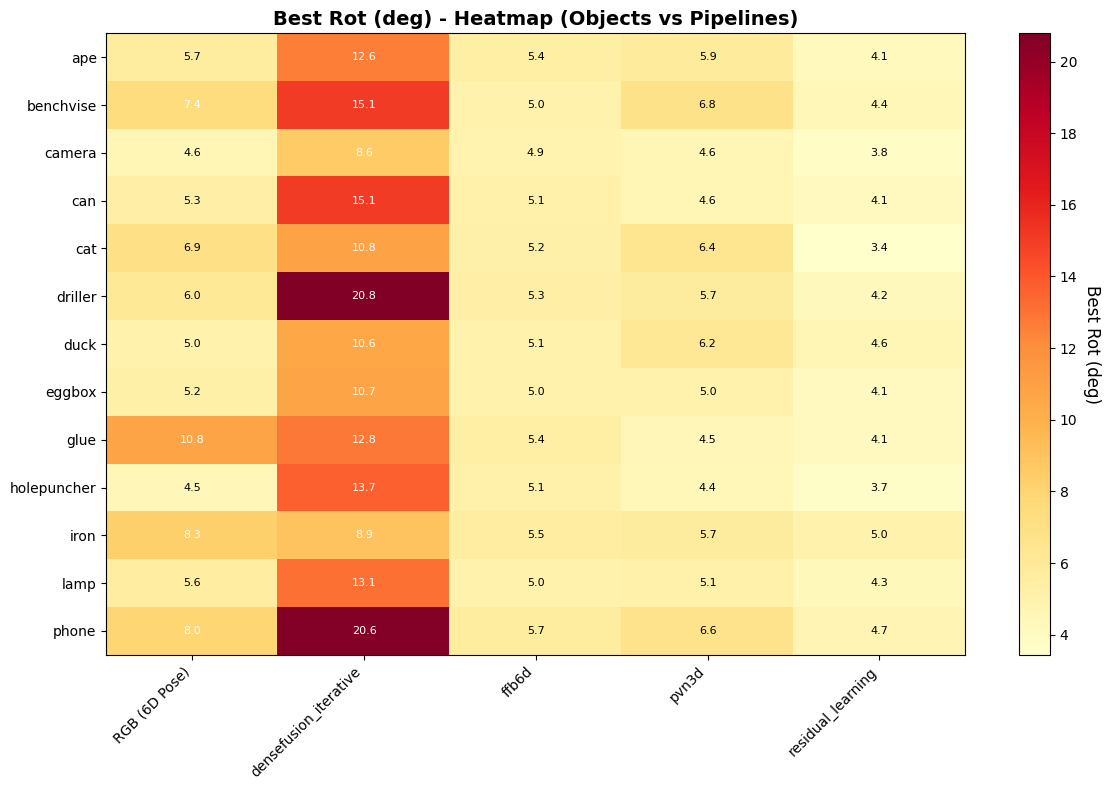

In [21]:
# Plot rotation error heatmap
if results_df is not None:
    plot_error_heatmap(results_df, 'Best Rot (deg)')

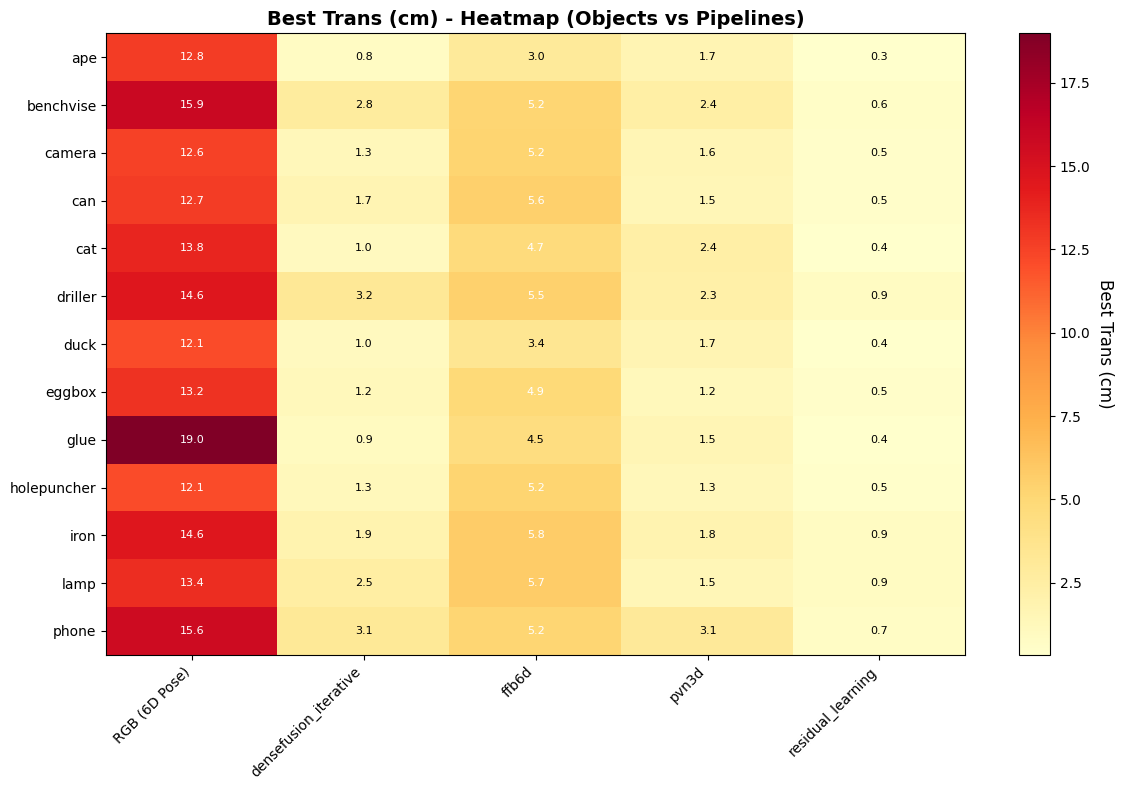

In [22]:
# Plot translation error heatmap
if results_df is not None:
    plot_error_heatmap(results_df, 'Best Trans (cm)')

## 7. Best Model Selection

In [23]:
def find_best_model_per_object(df):
    """
    Find the best performing model for each object.
    
    Args:
        df: Results DataFrame
    
    Returns:
        DataFrame with best model per object
    """
    if df is None:
        return None
    
    best_rot = df.loc[df.groupby('Object')['Best Rot (deg)'].idxmin()]
    best_rot = best_rot[['Object', 'Pipeline', 'Best Rot (deg)']].copy()
    best_rot.columns = ['Object', 'Best Model (Rot)', 'Rot Error (deg)']
    
    # For translation, filter out NaN values
    df_trans = df.dropna(subset=['Best Trans (cm)'])
    if len(df_trans) > 0:
        best_trans = df_trans.loc[df_trans.groupby('Object')['Best Trans (cm)'].idxmin()]
        best_trans = best_trans[['Object', 'Pipeline', 'Best Trans (cm)']].copy()
        best_trans.columns = ['Object', 'Best Model (Trans)', 'Trans Error (cm)']
        
        result = best_rot.merge(best_trans, on='Object', how='left')
    else:
        result = best_rot
        result['Best Model (Trans)'] = 'N/A'
        result['Trans Error (cm)'] = np.nan
    
    return result

In [24]:
# Find best model per object
if results_df is not None:
    best_models_df = find_best_model_per_object(results_df)
    
    print("Best Model per Object")
    print("=" * 100)
    print(best_models_df.to_string(index=False))
    print("=" * 100)
    
    # Count wins per model
    print("\nModel Win Count (Best Rotation Error):")
    print(best_models_df['Best Model (Rot)'].value_counts().to_string())
    
    if 'Best Model (Trans)' in best_models_df.columns:
        print("\nModel Win Count (Best Translation Error):")
        trans_counts = best_models_df['Best Model (Trans)'].value_counts()
        trans_counts = trans_counts[trans_counts.index != 'N/A']
        print(trans_counts.to_string())

Best Model per Object
     Object  Best Model (Rot)  Rot Error (deg) Best Model (Trans)  Trans Error (cm)
        ape residual_learning         4.125521  residual_learning          0.335542
  benchvise residual_learning         4.414115  residual_learning          0.588527
     camera residual_learning         3.787480  residual_learning          0.497895
        can residual_learning         4.085982  residual_learning          0.518275
        cat residual_learning         3.438767  residual_learning          0.352286
    driller residual_learning         4.249338  residual_learning          0.907222
       duck residual_learning         4.572536  residual_learning          0.350742
     eggbox residual_learning         4.115150  residual_learning          0.502834
       glue residual_learning         4.099123  residual_learning          0.394393
holepuncher residual_learning         3.700121  residual_learning          0.477113
       iron residual_learning         5.023832  residu

## 8. Export Results

In [25]:
# Export results to CSV
if results_df is not None:
    output_dir = '../logs'
    os.makedirs(output_dir, exist_ok=True)
    
    # Full results
    results_df.to_csv(os.path.join(output_dir, 'training_results_all_objects.csv'), index=False)
    print(f"Results saved to {output_dir}/training_results_all_objects.csv")
    
    # Summary
    if summary_df is not None:
        summary_df.to_csv(os.path.join(output_dir, 'model_summary.csv'), index=False)
        print(f"Summary saved to {output_dir}/model_summary.csv")
    
    # Best models
    if best_models_df is not None:
        best_models_df.to_csv(os.path.join(output_dir, 'best_models_per_object.csv'), index=False)
        print(f"Best models saved to {output_dir}/best_models_per_object.csv")

Results saved to ../logs/training_results_all_objects.csv
Summary saved to ../logs/model_summary.csv
Best models saved to ../logs/best_models_per_object.csv
